<a href="https://colab.research.google.com/github/nickmonozon/PARISlab/blob/main/gpr_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scalable pipeline for concrete pump size classification

This notebook establishes a robust approach to classifying concrete pump size (2", 3" or 4") based on the gradiation of coarse and fine aggregates in concrete materials using Gaussian Process Regression-based approach (`GPflow` implementation). Major sections in the notebook are as follows:

1. Data preprocessing and stratified train-test-split
2. Exploratory data analysis
3. Model training and evaluation
4. SHAP analysis and feature importance
5. k-means clustering and LOCO-CV

The model is currently evaluated on a small subset of important features identified by the included SHAP analysis.

### File Import

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving concrete_mixtures_updated.xlsx to concrete_mixtures_updated.xlsx


### Library Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import matplotlib.cm as cm
# !pip install openpyxl==3.0.9
import warnings
import tensorflow as tf
from google.colab import files
warnings.filterwarnings("ignore")

### GPU Acceleration

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Graphics Setups

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
 # plt.rc('font', family='Arial') 
plt.rc('font', size=12)
# plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = False
plt.rcParams['axes.linewidth'] = 2

### Data Preprocessing Pipeline

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
DATA_DIR= "concrete_mixtures_updated.xlsx"
RANDOM_SEED = 3
REPETITION = 50

def get_arguments():
    parser = argparse.ArgumentParser(description="Network")
    parser.add_argument("--random-seed", type=int, default=RANDOM_SEED)
    parser.add_argument("--data-dir", type=str, default=DATA_DIR)
    parser.add_argument("--repetition", type=int, default=REPETITION)
    return parser.parse_args()

# args = get_arguments()

def stratification(Y, n=10, test_ratio=0.1, rnd=1, ind=0):
    Y_train=pd.DataFrame([])
    Y_test=pd.DataFrame([])

    for count,i in enumerate(np.linspace(0,len(Y.iloc[:,ind]),n+1)): # rank by distribution
        if count==0:
            j=i
        else:
            Y_sp = Y.loc[Y.iloc[:,ind].nsmallest(round(i)).index.difference(Y.iloc[:,ind].nsmallest(round(j)).index)]
            Y_train_sp, Y_test_sp = train_test_split(Y_sp, test_size = test_ratio, random_state = rnd+count) # random_state = l+80
            Y_train=pd.concat([Y_train,Y_train_sp])
            Y_test=pd.concat([Y_test,Y_test_sp])
            j=i
    del count, i, j, Y_train_sp, Y_test_sp, Y_sp
    return Y_train, Y_test

# data import
data_raw=pd.read_excel("concrete_mixtures_updated.xlsx",sheet_name=0,index_col=0).drop(['Code', 'Description'], axis=1)
data_raw.fillna(0,inplace=True)
data_name=list(data_raw) 
data_raw.reset_index(drop=True,inplace=True)
# get the features
data_feature = data_raw.iloc[:, 0:-1]
# get the label
data_label = data_raw.iloc[:, [-1]]
# drop slump (all zeros)
# data_feature.drop(["slump"], inplace=True, axis=1)

# # extract the nominal maximum agg size using regex
# import re
# pat = "((\d+)mm)"
# nmas = [int(re.findall(pat, value)[0][1]) for value in data_feature["Nominal maximum agg size"].values]
# data_feature["Nominal maximum agg size"] = nmas

# feature scaling
scaler1 = preprocessing.StandardScaler() 
data_feature_scaled=scaler1.fit_transform(data_feature) 
data_feature_scaled=pd.DataFrame(data_feature_scaled, columns=data_feature.columns)
# label scaling
scaler2 = preprocessing.StandardScaler() 
data_label_scaled=scaler2.fit_transform(data_label.values.reshape(-1,1)) 
data_label_scaled=pd.DataFrame(data_label_scaled, columns=[data_label.columns[0]])

# train-test-split using stratification
for i in range(REPETITION):
    Y_train, Y_test=stratification(data_label_scaled, n=10, test_ratio=0.15, rnd=RANDOM_SEED+i, ind=1-1)
    Y_train.sort_index(inplace=True)
    Y_test.sort_index(inplace=True)
    X_train=data_feature_scaled.loc[Y_train.index] 
    X_test=data_feature_scaled.loc[Y_test.index]
    Y_train=data_label_scaled.loc[Y_train.index]
    Y_test=data_label_scaled.loc[Y_test.index]

y_train = Y_train.copy()
y_test = Y_test.copy()

In [ ]:
# rename the columns
X_train.columns = ['w/cm', 'cementitious', 'Coarse agg total', 'Fine agg total',
       'Coarse agg (>1/2" )', 'Coarse agg (<1/2" )', '2" (50mm)', '1" (25mm)',
       '3/4" (19mm)', '1/2" (12.5mm)', '3/8" (9.5mm)', '#4 (4.75mm)',
       '#8 (2.36mm)', '#16 (1.18mm)', '#30 (.6mm)', '#50 (.3mm)',
       '#100 (.15mm)', '#200 (75µm)']
X_test.columns = list(X_train.columns)

In [ ]:
# only selecting the relative set of features
# feat = ['w/cm', 'cementitious', '2" (50mm)', '1" (25mm)',
#        '3/4" (19mm)', '1/2" (12.5mm)', '3/8" (9.5mm)', '#4 (4.75mm)',
#        '#8 (2.36mm)', '#16 (1.18mm)', '#30 (.6mm)', '#50 (.3mm)',
#        '#100 (.15mm)', '#200 (75µm)']
# For sparse model
feat = ['cementitious', 'w/cm', '3/4" (19mm)', '1/2" (12.5mm)', '#30 (.6mm)', '#50 (.3mm)']
X_train = X_train.loc[:, feat]
X_test = X_test.loc[:, feat]
# X_train.drop(['2" (50mm)'], inplace=True, axis=1)
# X_test.drop(['2" (50mm)'], inplace=True, axis=1)
# create X and y dataframes
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
df = pd.concat([X, y], axis=1)

In [ ]:
df.drop(["Labeled pipe size"], axis = 1)

,cementitious,w/cm,"3/4"" (19mm)","1/2"" (12.5mm)",#30 (.6mm),#50 (.3mm)
0,-0.090468,0.013438,-1.409259,-1.333921,0.445363,0.428736
1,0.287103,0.013438,-1.409259,-1.547102,1.491785,-1.095405
2,1.625764,-0.652487,-1.409259,-1.547102,1.162602,-1.285132
3,0.012506,0.489098,-1.409259,-1.547102,1.370360,-1.165389
4,1.602881,-0.557355,-1.409259,-1.466863,2.109815,2.973382
...,...,...,...,...,...,...
5850,-1.440571,0.774495,0.620368,0.554712,-0.329012,0.610385
5851,-1.440571,0.774495,0.661158,0.463676,-0.134825,0.797135
5857,-0.685429,0.298834,0.833877,0.435328,-0.072566,-0.590847
5866,-0.685429,0.298834,0.454644,0.743353,-0.466856,-0.895931


In [ ]:
X_train.head()

,cementitious,w/cm,"3/4"" (19mm)","1/2"" (12.5mm)",#30 (.6mm),#50 (.3mm)
0,-0.090468,0.013438,-1.409259,-1.333921,0.445363,0.428736
1,0.287103,0.013438,-1.409259,-1.547102,1.491785,-1.095405
2,1.625764,-0.652487,-1.409259,-1.547102,1.162602,-1.285132
3,0.012506,0.489098,-1.409259,-1.547102,1.370360,-1.165389
4,1.602881,-0.557355,-1.409259,-1.466863,2.109815,2.973382


In [ ]:
y_train.head()

,Labeled pipe size
0,-1.771763
1,-1.771763
2,-1.771763
3,-1.771763
4,-1.771763


### EDA

Correlation Heatmap

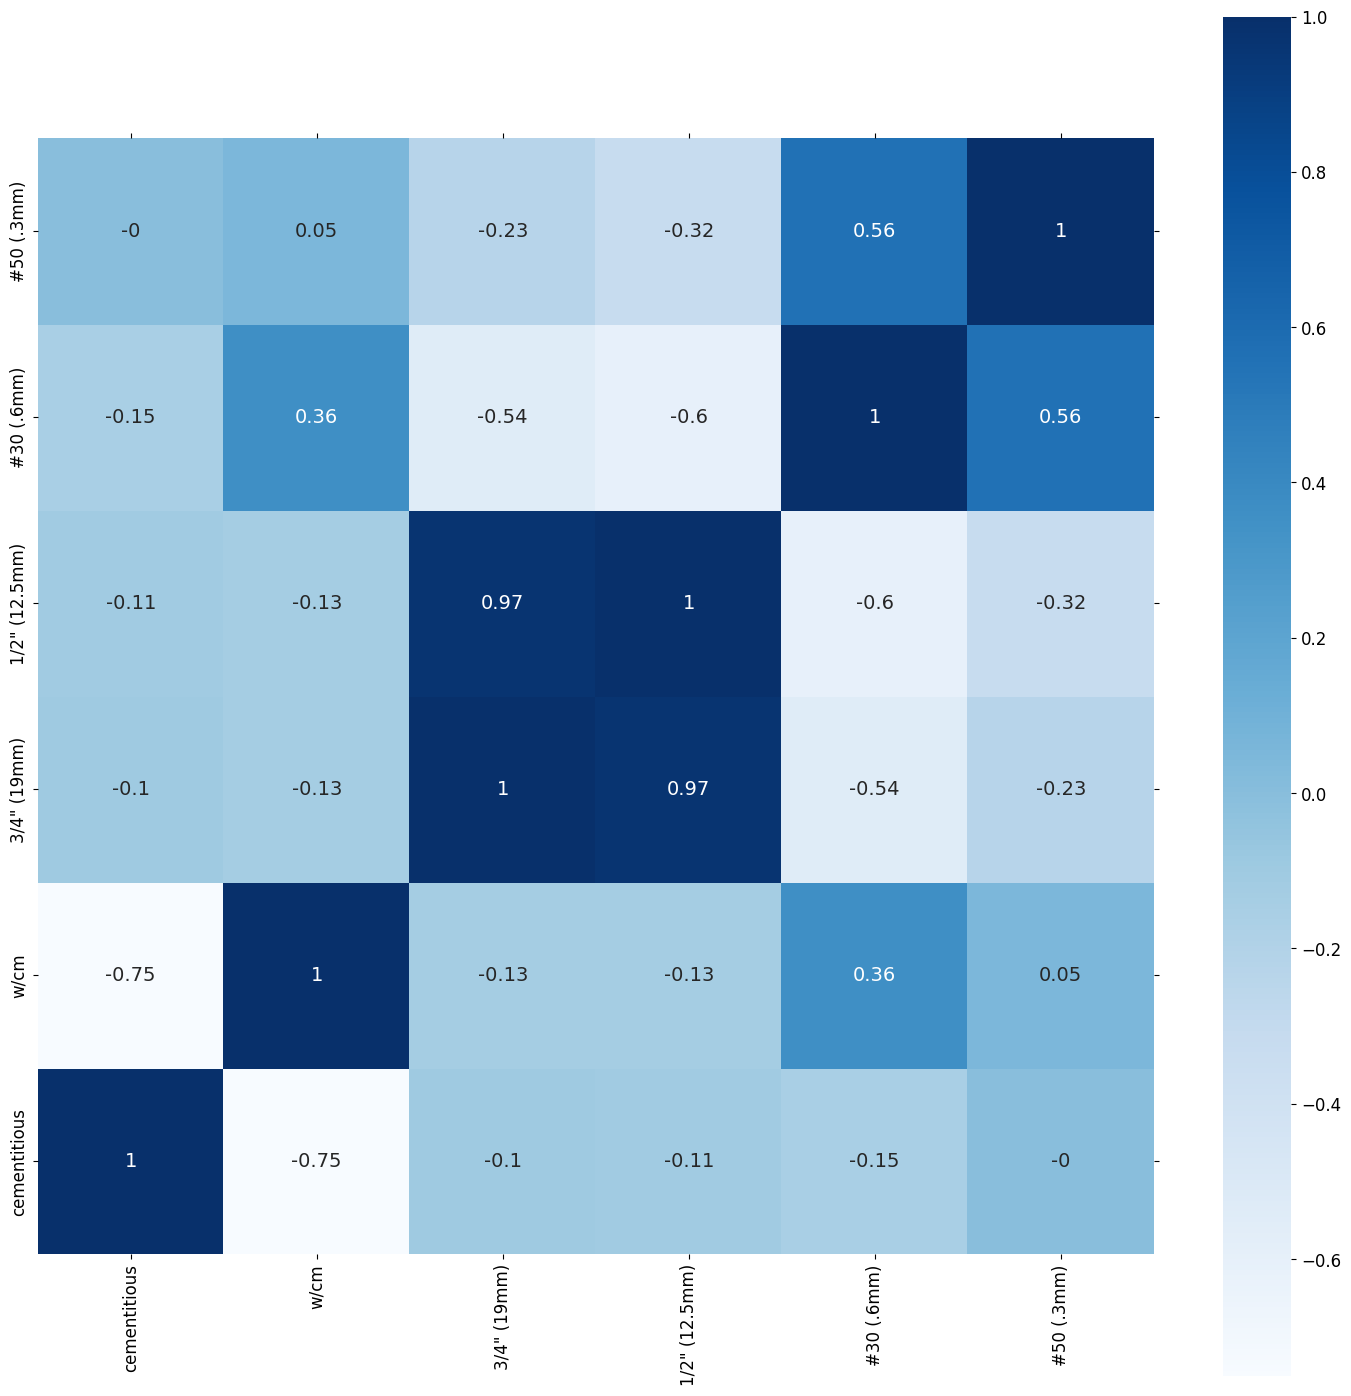

In [ ]:
n = df.shape[1] - 1
plt.figure(figsize = (18, 18), dpi=100)
sns.heatmap(np.round(df.drop(columns=['Labeled pipe size']).corr(), 2), annot = True, square=True, annot_kws={"fontsize":14}, cmap="Blues")
plt.xlim([0, n])
plt.ylim([0, n])
plt.xticks(rotation=90)
plt.show()

Distplots

In [ ]:
scaler3 = preprocessing.StandardScaler()
scaler3.fit(data_feature.loc[:, X.columns]) 
samples = pd.DataFrame(scaler3.inverse_transform(df.loc[:, X.columns]))
samples.columns = X.columns
true_target = pd.DataFrame(scaler2.inverse_transform(df.iloc[:, -1].values.reshape(-1,1)), columns=["Pump size"])

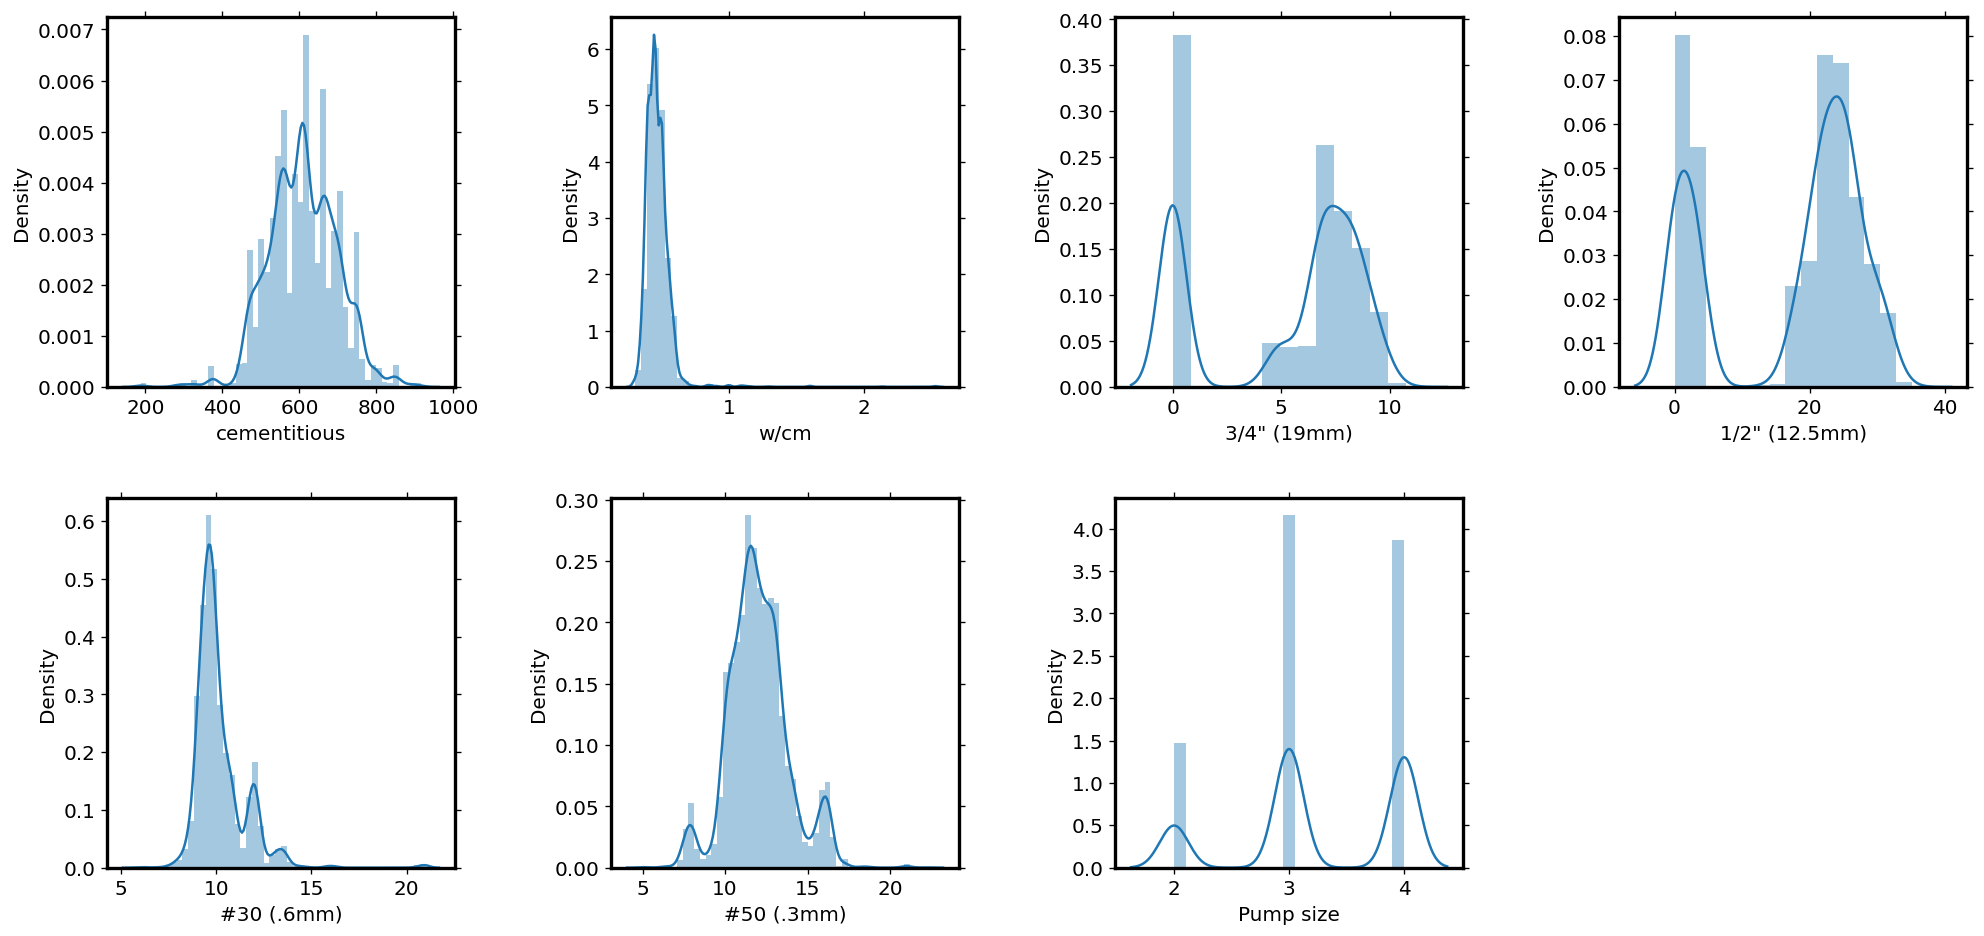

In [ ]:
plt.figure(figsize = (20, 20), dpi=120)
plt.subplots_adjust(wspace = 0.45, hspace = 0.3)
for i in range(df.shape[1]-1):
    plt.subplot(4, 4, i+1)
    plt.xlabel(df.columns[i])
    sns.distplot(samples.iloc[:, i], norm_hist=True)
plt.subplot(4, 4, i+2)
sns.distplot(true_target["Pump size"], norm_hist=True)
# plt.savefig('displots_n.png')
# files.download('displots_n.png')
plt.show()

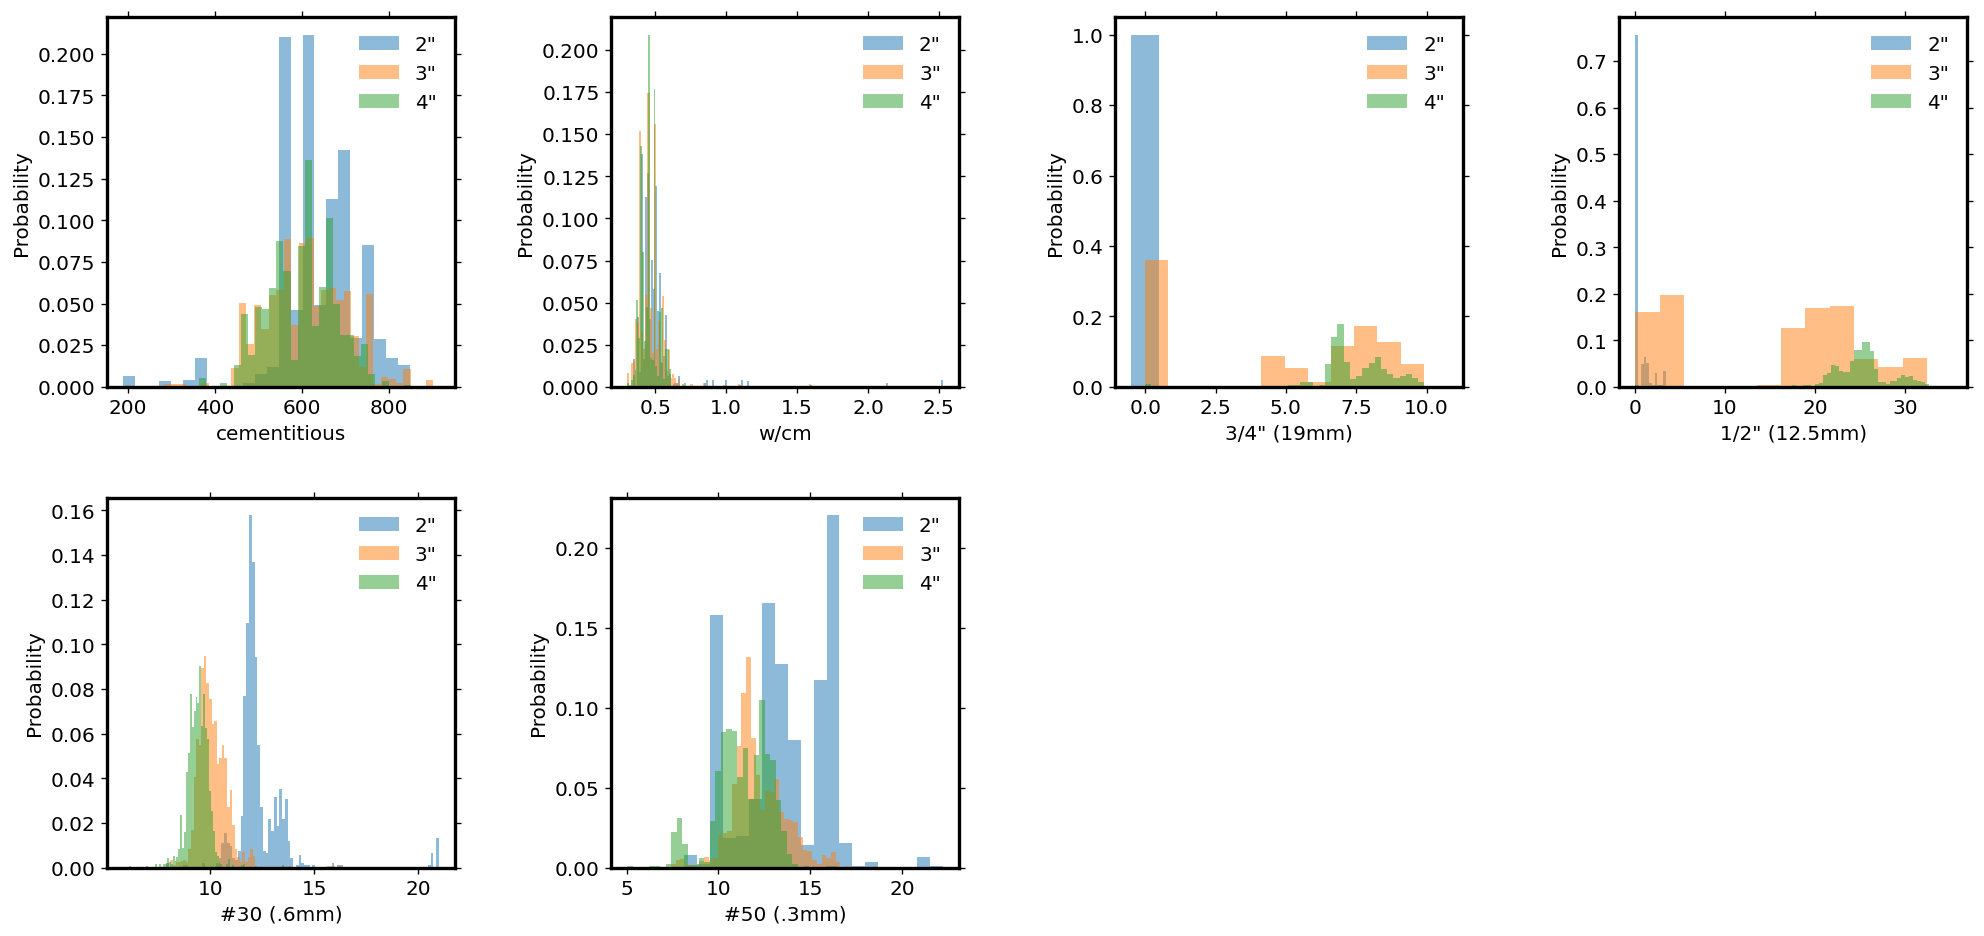

In [ ]:
# color the distribution base on the label class
plt.figure(figsize = (20, 20), dpi=120)
plt.subplots_adjust(wspace = 0.45, hspace = 0.3)
for i in range(df.shape[1]-1):
    plt.subplot(4, 4, i+1)
    plt.xlabel(df.columns[i])
    sns.histplot(samples.iloc[:, i].loc[true_target["Pump size"] == 2], label='2"', stat="probability", color="C0", alpha=0.5, edgecolor="none")
    sns.histplot(samples.iloc[:, i].loc[true_target["Pump size"] == 3], label='3"', stat="probability", color="C1", alpha=0.5, edgecolor="none")
    sns.histplot(samples.iloc[:, i].loc[true_target["Pump size"] == 4], label='4"', stat="probability", color="C2", alpha=0.5, edgecolor="none")
    plt.legend(frameon=False)
plt.show()

Train-test-split Visualization

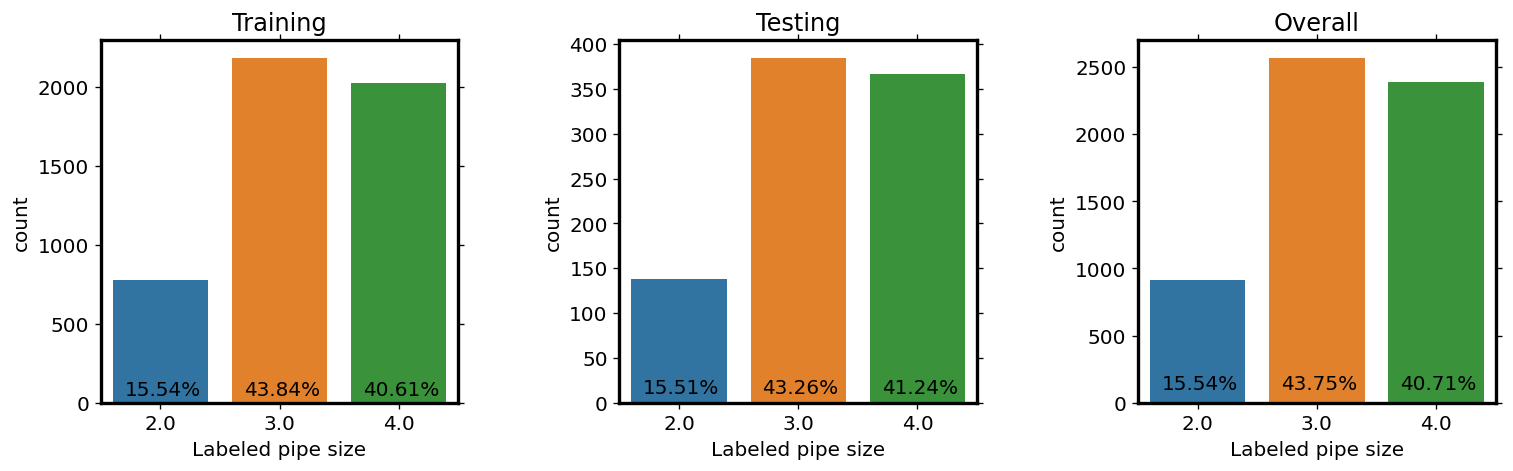

In [ ]:
plt.figure(figsize = (15, 4), dpi=120)
plt.subplots_adjust(wspace = 0.45, hspace = 0.3)
yheight = [50, 10, 100]
labels = [pd.DataFrame(scaler2.inverse_transform(y_train), columns=["Labeled pipe size"]), 
          pd.DataFrame(scaler2.inverse_transform(y_test), columns=["Labeled pipe size"]), 
          pd.DataFrame(scaler2.inverse_transform(df[["Labeled pipe size"]]), columns=["Labeled pipe size"])]
leds = ['Training', "Testing", "Overall"]
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.xlabel("Labeled pipe size")
    sns.countplot(x="Labeled pipe size", data=labels[i])
    plt.text(-0.3, yheight[i], "%.2f%%" %(np.mean(labels[i] == 2) * 100))
    plt.text(0.7, yheight[i], "%.2f%%" %(np.mean(labels[i] == 3) * 100))
    plt.text(1.7, yheight[i], "%.2f%%" %(np.mean(labels[i] == 4) * 100))
    plt.title(leds[i])

# plt.savefig('train_test_sets.png')
# files.download('train_test_sets.png')
plt.show()

Correlation via barplot

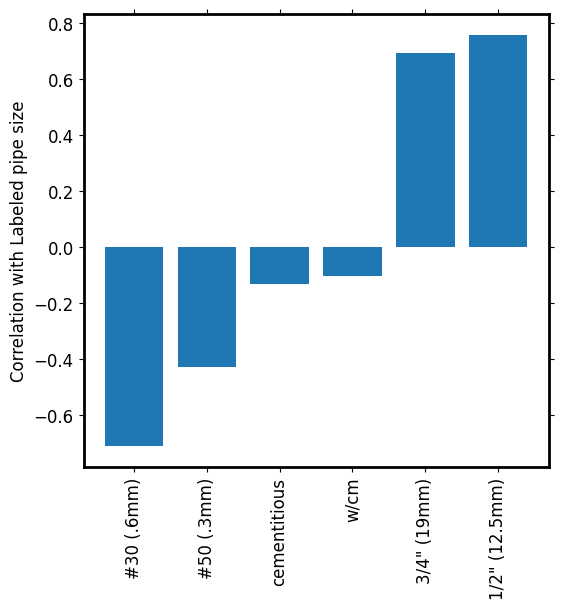

In [ ]:
target = "Labeled pipe size"
correlation = np.round(df.corr()[target], 2)
plt.figure(figsize=(6,6), dpi=100)
plt.bar(list(range(df.shape[1]-1)), df.corr()[target].sort_values().values[:-1])
plt.xticks(list(range(df.shape[1]-1)), df.corr()[target].sort_values().index[:-1], 
           rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Correlation with %s" %target)
plt.show()

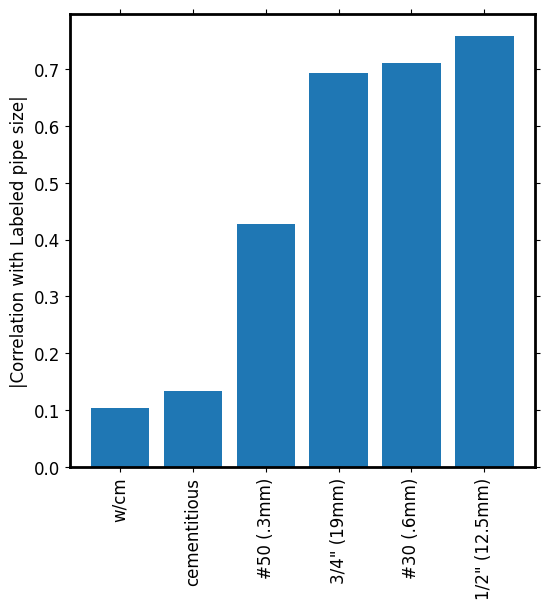

In [ ]:
correlation = np.round(df.corr()[target], 2)
plt.figure(figsize=(6,6), dpi=100)
plt.bar(list(range(df.shape[1]-1)), np.abs(df.corr()[target]).sort_values().values[:-1])
plt.xticks(list(range(df.shape[1]-1)), np.abs(df.corr()[target]).sort_values().index[:-1], 
           rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("|Correlation with %s|" %target)
plt.show()

### GPR Modeling

In [ ]:
# package install and import
!pip install gpflow
import gpflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class MyScaler:
    '''
    Cutomized scaler to scale the predictions and std, 
    or to reverse back to the original scale.
    '''
    def __init__(self):
        pass

    def fit(self, x):
        self.mu  = np.mean(x)
        self.std = np.std(x)

    def transform(self, x):
        return (x-self.mu)/self.std

    def inverse_transform_mean(self, x):
        '''To transform mean'''
        return x*self.std + self.mu

    def inverse_transform_std(self, x):
        '''To transform standard deviation'''
        return x*self.std

Model Fitting

In [ ]:
# contructing the model
k = gpflow.kernels.Linear() + gpflow.kernels.RBF()
m = gpflow.models.GPR(data=(X_train, y_train), 
                      kernel=k, mean_function=None)
# gpflow.mean_functions.Linear(A=np.zeros(X_train.shape[1]).reshape(-1, 1))
m.likelihood.variance.assign(0.39)
gpflow.set_trainable(m.likelihood.variance, False)
# auto-optimization
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(m.training_loss, variables=m.trainable_variables, 
                   options=dict(maxiters=5000, disp=True))
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0293113
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.371974
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.03888
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.39


Model Evaluation: Training Set

In [ ]:
# predict the mean and variance of latent GP at training data points
from sklearn.metrics import r2_score, mean_squared_error
mean, var = m.predict_f(X_train.values)
r2_score(y_train, mean.numpy().reshape(1,-1)[0])

0.8417381835519565

In [ ]:
# inverse the predictions and the stds back to the original scales
preds_train = scaler2.inverse_transform(mean.numpy().reshape(-1,1))
y_train_original = scaler2.inverse_transform(y_train)
y_test_original = scaler2.inverse_transform(y_test)
y_original = np.concatenate([y_train_original, y_test_original]).reshape(1,-1)[0]
y_scaler = MyScaler()
y_scaler.fit(y_original)
stds = y_scaler.inverse_transform_std(np.sqrt(var.numpy().reshape(1,-1)[0]))
# compute the r2, rmse and ci width
r2 = r2_score(y_train_original, preds_train)
rmse = np.sqrt(mean_squared_error(y_train_original, preds_train))
ci = 1.96 * stds
y_pred = preds_train.reshape(1, -1)[0]

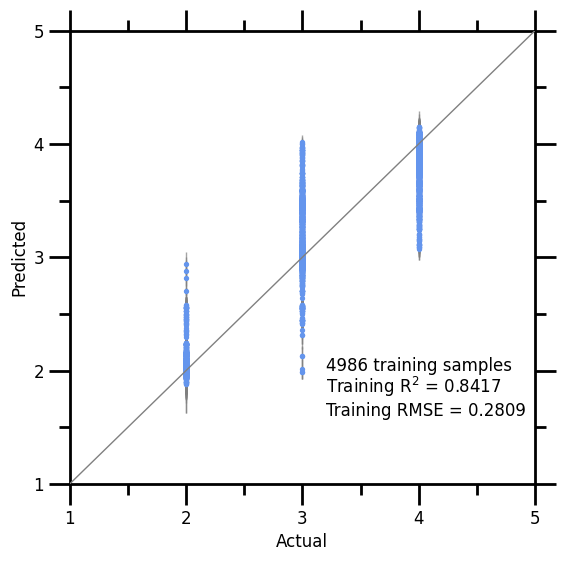

In [ ]:
plt.figure(figsize=(6,6), dpi=100)
plt.plot([1, 5],[1, 5], color="grey", label="theoretical", zorder = 4, linewidth=1)
plt.errorbar(y_train_original, y_pred, stds, elinewidth=1, ecolor="tab:grey", alpha = 0.7, ls="None") 
plt.scatter(y_train_original, y_pred, s=5+3, zorder=4, color="cornflowerblue")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.xlim([1, 5]); plt.ylim([1, 5])
plt.text(3.2, 2, "%d training samples" %X_train.shape[0], fontsize=12)
plt.text(3.2, 1.8, "Training R$^2$ = %.4f" %round(r2,4), fontsize=12)
plt.text(3.2, 1.6, "Training RMSE = %.4f" %round(rmse,4), fontsize=12)
plt.axes().yaxis.set_major_locator(MultipleLocator(1))
plt.axes().yaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().xaxis.set_major_locator(MultipleLocator(1))
plt.axes().xaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().tick_params(which='major', length=15,width=2)
plt.axes().tick_params(which='minor', length=8,width=2)
plt.axes().tick_params(axis='y', labelright=False)
# plt.savefig('training.jpg')
# files.download('training.jpg')
plt.show()

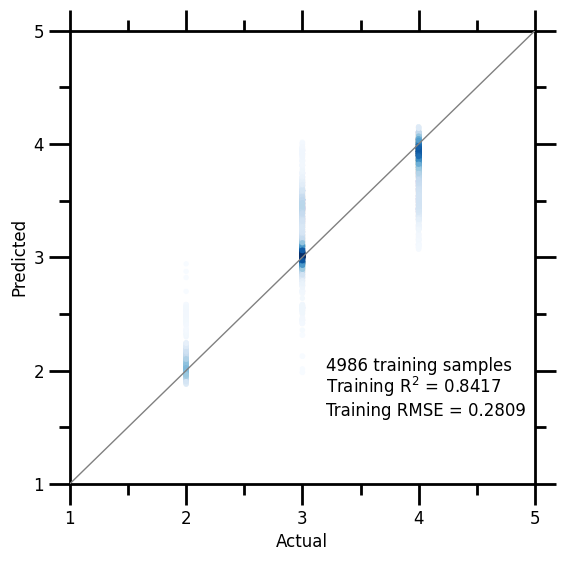

In [ ]:
# With density
plt.figure(figsize=(6,6), dpi=100)
plt.plot([1, 5],[1, 5], color="grey", label="theoretical", zorder = 4, linewidth=1)
xy = np.vstack([y_train_original.reshape(1, -1), y_pred.reshape(1, -1)])
z = gaussian_kde(xy)(xy)
# plt.errorbar(y_train_original, y_pred, stds, elinewidth=1, ecolor="cornflowerblue", ls="None") 
plt.scatter(y_train_original, y_pred, s=5+3, zorder=4, c=z, cmap=cm.Blues)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.xlim([1, 5]); plt.ylim([1, 5])
plt.text(3.2, 2, "%d training samples" %X_train.shape[0], fontsize=12)
plt.text(3.2, 1.8, "Training R$^2$ = %.4f" %round(r2,4), fontsize=12)
plt.text(3.2, 1.6, "Training RMSE = %.4f" %round(rmse,4), fontsize=12)
plt.axes().yaxis.set_major_locator(MultipleLocator(1))
plt.axes().yaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().xaxis.set_major_locator(MultipleLocator(1))
plt.axes().xaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().tick_params(which='major', length=15,width=2)
plt.axes().tick_params(which='minor', length=8,width=2)
plt.axes().tick_params(axis='y', labelright=False)
# plt.savefig('training_density.jpg')
# files.download('training_density.jpg')
plt.show()

Model Evaluation: Testing Set

In [ ]:
# predict the mean and variance of latent GP at testing data points
mean, var = m.predict_f(X_test.values)
r2_score(y_test, mean.numpy().reshape(1,-1)[0])

0.8349443252134551

In [ ]:
preds_test = scaler2.inverse_transform(mean.numpy().reshape(-1,1))
stds = y_scaler.inverse_transform_std(np.sqrt(var.numpy().reshape(1,-1)[0]))
r2 = r2_score(y_test_original, preds_test)
rmse = np.sqrt(mean_squared_error(y_test_original, preds_test))
ci = 1.96 * stds
y_pred = preds_test.reshape(1, -1)[0]

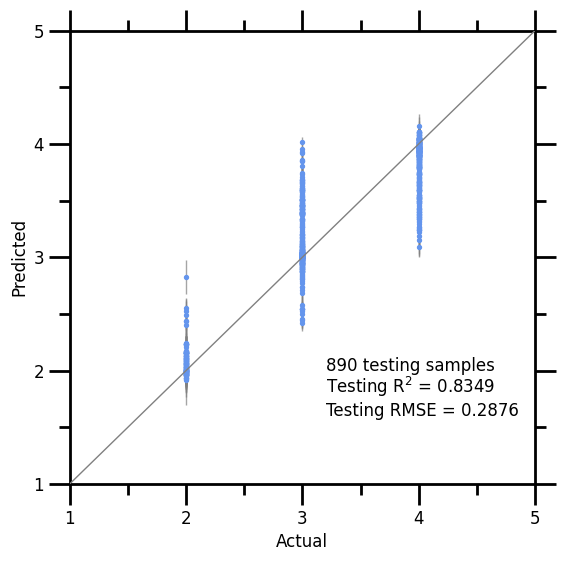

In [ ]:
plt.figure(figsize=(6,6),dpi=100)
plt.plot([1, 5],[1, 5], color="grey", label="theoretical", zorder = 4, linewidth=1)
plt.errorbar(y_test_original, y_pred, stds, elinewidth=1, ecolor="tab:grey", alpha =0.7, ls="None") 
plt.scatter(y_test_original, y_pred, s=5+3, zorder=4, color="cornflowerblue")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.xlim([1, 5]); plt.ylim([1, 5])
plt.text(3.2, 2, "%d testing samples" %X_test.shape[0], fontsize=12)
plt.text(3.2, 1.8, "Testing R$^2$ = %.4f" %round(r2,4), fontsize=12)
plt.text(3.2, 1.6, "Testing RMSE = %.4f" %round(rmse,4), fontsize=12)
plt.axes().yaxis.set_major_locator(MultipleLocator(1))
plt.axes().yaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().xaxis.set_major_locator(MultipleLocator(1))
plt.axes().xaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().tick_params(which='major', length=15,width=2)
plt.axes().tick_params(which='minor', length=8,width=2)
plt.axes().tick_params(axis='y', labelright=False)
plt.savefig('testing.jpg')
# files.download('testing.jpg')
plt.show()

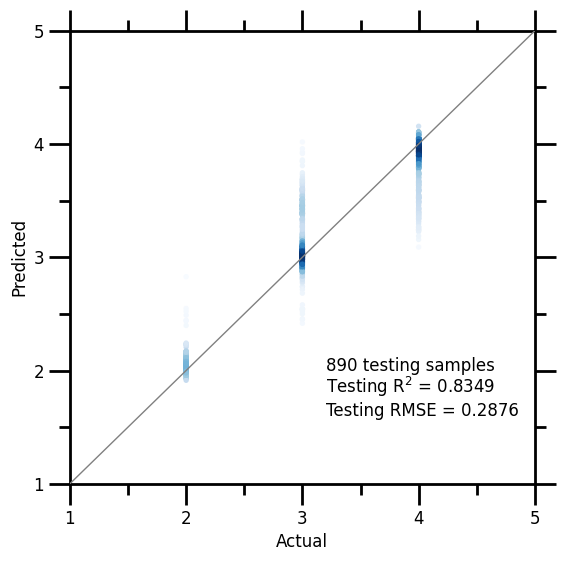

In [ ]:
# With density
plt.figure(figsize=(6,6),dpi=100)
plt.plot([1, 5],[1, 5], color="grey", label="theoretical", zorder = 4, linewidth=1)
xy = np.vstack([y_test_original.reshape(1, -1), y_pred.reshape(1, -1)])
z = gaussian_kde(xy)(xy)
# plt.errorbar(y_test_original, y_pred, stds, elinewidth=1, ecolor="cornflowerblue", ls="None") 
plt.scatter(y_test_original, y_pred, s=5+3, zorder=4, c=z, cmap=cm.Blues)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.xlim([1, 5]); plt.ylim([1, 5])
plt.text(3.2, 2, "%d testing samples" %X_test.shape[0], fontsize=12)
plt.text(3.2, 1.8, "Testing R$^2$ = %.4f" %round(r2,4), fontsize=12)
plt.text(3.2, 1.6, "Testing RMSE = %.4f" %round(rmse,4), fontsize=12)
plt.axes().yaxis.set_major_locator(MultipleLocator(1))
plt.axes().yaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().xaxis.set_major_locator(MultipleLocator(1))
plt.axes().xaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().tick_params(which='major', length=15,width=2)
plt.axes().tick_params(which='minor', length=8,width=2)
plt.axes().tick_params(axis='y', labelright=False)
plt.savefig('testing_density.jpg')
# files.download('testing_density.jpg')
plt.show()

Regression to Classification

In [ ]:
# predict the mean and variance of latent GP at all the data points
mean, var = m.predict_f(X.values)
preds = scaler2.inverse_transform(mean.numpy().reshape(-1,1))
stds = y_scaler.inverse_transform_std(np.sqrt(var.numpy().reshape(1,-1)[0]))
r2 = r2_score(y_original, preds)
rmse = np.sqrt(mean_squared_error(y_original, preds))
ci = 1.96 * stds
y_pred = preds.reshape(1, -1)[0]

# Appending to original dataset
predicted_size = y_pred.copy()

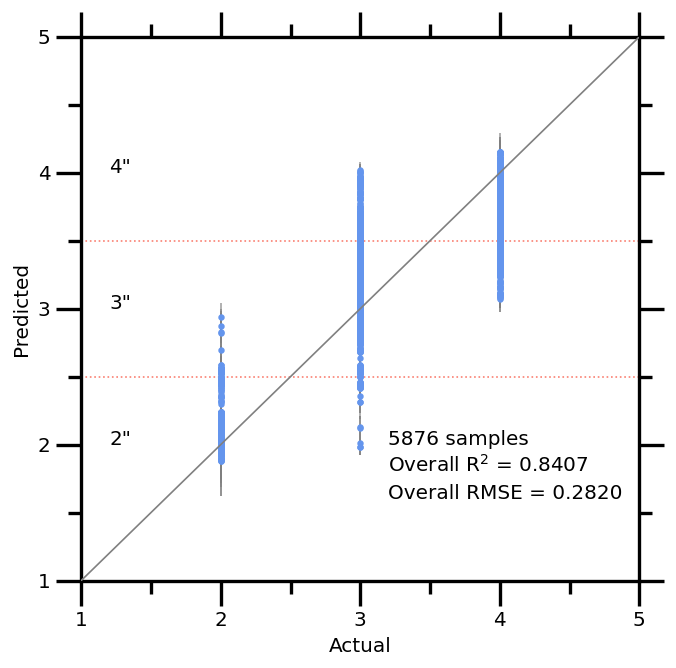

In [ ]:
plt.figure(figsize=(6,6),dpi=120)
plt.plot([1, 5],[1, 5], color="grey", label="theoretical", zorder = 4, linewidth=1)
plt.plot([1, 5], [2.5, 2.5], ":", linewidth=1, color="salmon")
plt.plot([1, 5], [3.5, 3.5], ":", linewidth=1, color="salmon")
plt.text(1.2, 2, '2"')
plt.text(1.2, 3, '3"')
plt.text(1.2, 4, '4"')
plt.errorbar(y_original, y_pred, stds, elinewidth=1, ecolor="tab:grey", alpha=0.7, ls="None") 
plt.scatter(y_original, y_pred, s=5+3, zorder=4, color="cornflowerblue")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.xlim([1, 5]); plt.ylim([1, 5])
plt.text(3.2, 2, "%d samples" %X.shape[0], fontsize=12)
plt.text(3.2, 1.8, "Overall R$^2$ = %.4f" %round(r2,4), fontsize=12)
plt.text(3.2, 1.6, "Overall RMSE = %.4f" %round(rmse,4), fontsize=12)
plt.axes().yaxis.set_major_locator(MultipleLocator(1))
plt.axes().yaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().xaxis.set_major_locator(MultipleLocator(1))
plt.axes().xaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().tick_params(which='major', length=15,width=2)
plt.axes().tick_params(which='minor', length=8,width=2)
plt.axes().tick_params(axis='y', labelright=False)
# plt.savefig('overall.png')
# files.download('overall.png')
plt.show()

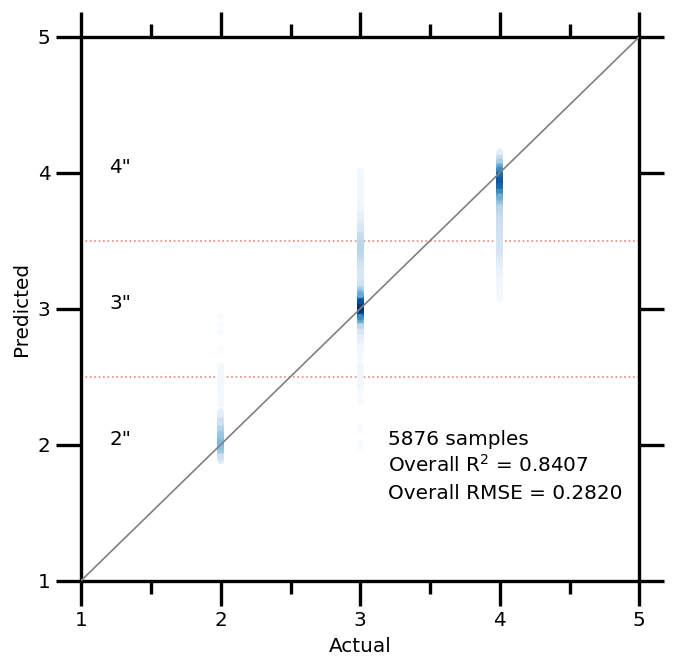

In [ ]:
# With density
plt.figure(figsize=(6,6),dpi=120)
xy = np.vstack([y_original.reshape(1, -1), y_pred.reshape(1, -1)])
z = gaussian_kde(xy)(xy)
plt.plot([1, 5],[1, 5], color="grey", label="theoretical", zorder = 4, linewidth=1)
plt.plot([1, 5], [2.5, 2.5], ":", linewidth=1, color="salmon")
plt.plot([1, 5], [3.5, 3.5], ":", linewidth=1, color="salmon")
plt.text(1.2, 2, '2"')
plt.text(1.2, 3, '3"')
plt.text(1.2, 4, '4"')
# plt.errorbar(y_original, y_pred, stds, elinewidth=1, ecolor="cornflowerblue", ls="None") 
plt.scatter(y_original, y_pred, s=5+3, zorder=4, c=z, cmap=cm.Blues)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.xlim([1, 5]); plt.ylim([1, 5])
plt.text(3.2, 2, "%d samples" %X.shape[0], fontsize=12)
plt.text(3.2, 1.8, "Overall R$^2$ = %.4f" %round(r2,4), fontsize=12)
plt.text(3.2, 1.6, "Overall RMSE = %.4f" %round(rmse,4), fontsize=12)
plt.axes().yaxis.set_major_locator(MultipleLocator(1))
# plt.axes().yaxis.set_bminor_locator(MultipleLocator(1/2))
plt.axes().xaxis.set_major_locator(MultipleLocator(1))
plt.axes().xaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().tick_params(which='major', length=15,width=2)
plt.axes().tick_params(which='minor', length=8,width=2)
plt.axes().tick_params(axis='y', labelright=False)
# plt.savefig('overall_density.png')
# files.download('overall_density.png')
plt.show()

Confusion Matrices

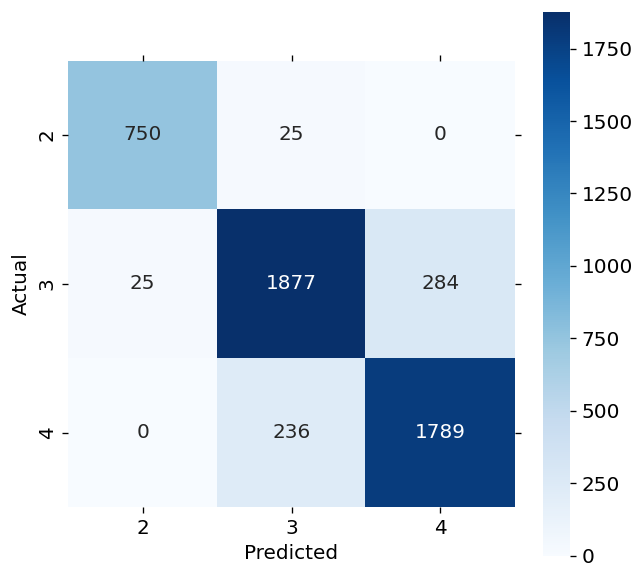

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6,6), dpi=120)
mean, var = m.predict_f(X_train.values)
preds_train = scaler2.inverse_transform(mean.numpy().reshape(-1,1))
stds = y_scaler.inverse_transform_std(np.sqrt(var.numpy().reshape(1,-1)[0]))
classified = [2 if val < 2.5 else 3 if val < 3.5 else 4 for val in preds_train]
labels = scaler2.inverse_transform(y_train.values.reshape(-1,1)).reshape(-1,1)
# training set performance
sns.heatmap(confusion_matrix(labels, classified), annot=True, square=True, fmt='g', cmap="Blues")
plt.yticks([0.5, 1.5, 2.5], [2, 3, 4])
plt.xticks([0.5, 1.5, 2.5], [2, 3, 4])
plt.ylabel("Actual")
plt.xlabel("Predicted")
# plt.savefig('training_confusion.png')
# files.download('training_confusion.png')
plt.show()

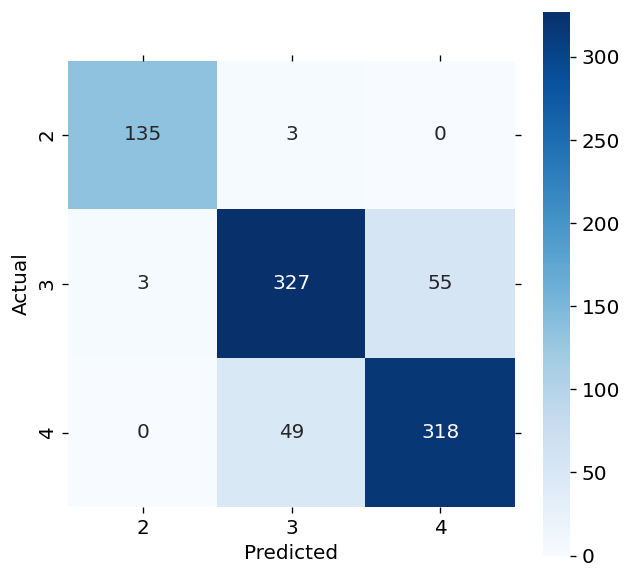

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6,6), dpi=120)
mean, var = m.predict_f(X_test.values)
preds_test = scaler2.inverse_transform(mean.numpy().reshape(-1,1))
stds = y_scaler.inverse_transform_std(np.sqrt(var.numpy().reshape(1,-1)[0]))
classified = [2 if val < 2.5 else 3 if val < 3.5 else 4 for val in preds_test]
labels = scaler2.inverse_transform(y_test.values.reshape(-1,1)).reshape(-1,1)
# testing set performance
sns.heatmap(confusion_matrix(labels, classified), annot=True, square=True, fmt='g', cmap="Blues")
plt.yticks([0.5, 1.5, 2.5], [2, 3, 4])
plt.xticks([0.5, 1.5, 2.5], [2, 3, 4])
plt.ylabel("Actual")
plt.xlabel("Predicted")
# plt.savefig('testing_confusion.png')
# files.download('testing_confusion.png')
plt.show()

### Classification Report: Precision, Recall, F-1 score and IoU

In [ ]:
# training set
mean, var = m.predict_f(X_train.values)
preds = scaler2.inverse_transform(mean.numpy().reshape(-1,1))
stds = y_scaler.inverse_transform_std(np.sqrt(var.numpy().reshape(1,-1)[0]))
classified = [2 if val < 2.5 else 3 if val < 3.5 else 4 for val in preds]
labels = scaler2.inverse_transform(y_train.values.reshape(-1,1)).reshape(-1,1)
from sklearn.metrics import classification_report
np.round(pd.DataFrame(classification_report(labels, classified, output_dict=True)).T, 4)

,precision,recall,f1-score,support
2.0,0.9511,0.9794,0.9650,775.0000
3.0,0.8927,0.8792,0.8859,2186.0000
4.0,0.8894,0.8938,0.8916,2025.0000
accuracy,0.9007,0.9007,0.9007,0.9007
macro avg,0.9111,0.9175,0.9142,4986.0000
weighted avg,0.9005,0.9007,0.9005,4986.0000


In [ ]:
from sklearn.metrics import jaccard_score
jaccard_score(labels, classified, average="weighted")

0.8202855560004605

In [ ]:
# testing set
mean, var = m.predict_f(X_test.values)
preds = scaler2.inverse_transform(mean.numpy().reshape(-1,1))
stds = y_scaler.inverse_transform_std(np.sqrt(var.numpy().reshape(1,-1)[0]))
classified = [2 if val < 2.5 else 3 if val < 3.5 else 4 for val in preds]
labels = scaler2.inverse_transform(y_test.values.reshape(-1,1)).reshape(-1,1)
from sklearn.metrics import classification_report
np.round(pd.DataFrame(classification_report(labels, classified, output_dict=True)).T, 4)

,precision,recall,f1-score,support
2.0,0.9448,0.9928,0.9682,138.0000
3.0,0.8727,0.8727,0.8727,385.0000
4.0,0.8861,0.8692,0.8776,367.0000
accuracy,0.8899,0.8899,0.8899,0.8899
macro avg,0.9012,0.9116,0.9062,890.0000
weighted avg,0.8894,0.8899,0.8895,890.0000


In [ ]:
from sklearn.metrics import jaccard_score
jaccard_score(labels, classified, average="weighted")

0.8028104429943193

In [ ]:
# from scipy.stats import pearsonr
# plt.figure(figsize=(12,8))
# plt.scatter(data_raw['3/8" (9.5mm)'], data_raw['#30 (.6mm)'], color="green", alpha = 0.5)
# plt.xlabel('3/8" (9.5mm)', fontsize=14)
# plt.ylabel('#30 (.6mm)', fontsize=14)
# plt.title('Scatterplot of 3/8" (9.5mm) and #30 (.6mm)')
# plt.savefig('scatterplot_features.png', dpi = 300)
# files.download('scatterplot_features.png')

### Evaluating on unseen data

In [ ]:
DATA_DIR= "concrete_mixtures_updated.xlsx"
RANDOM_SEED = 1213
REPETITION = 50

def get_arguments():
    parser = argparse.ArgumentParser(description="Network")
    parser.add_argument("--random-seed", type=int, default=RANDOM_SEED)
    parser.add_argument("--data-dir", type=str, default=DATA_DIR)
    parser.add_argument("--repetition", type=int, default=REPETITION)
    return parser.parse_args()

# args = get_arguments()

def stratification(Y, n=10, test_ratio=0, rnd=1, ind=0):
    Y_train=pd.DataFrame([])
    Y_test=pd.DataFrame([])

    for count,i in enumerate(np.linspace(0,len(Y.iloc[:,ind]),n+1)): # rank by distribution
        if count==0:
            j=i
        else:
            Y_sp = Y.loc[Y.iloc[:,ind].nsmallest(round(i)).index.difference(Y.iloc[:,ind].nsmallest(round(j)).index)]
            Y_train_sp, Y_test_sp = train_test_split(Y_sp, test_size = test_ratio, random_state = rnd+count) # random_state = l+80
            Y_train=pd.concat([Y_train,Y_train_sp])
            Y_test=pd.concat([Y_test,Y_test_sp])
            j=i
    del count, i, j, Y_train_sp, Y_test_sp, Y_sp
    return Y_train, Y_test

# data import
# data_raw_2=pd.read_excel("concrete_mixtures_updated.xlsx",sheet_name='test',index_col=0).drop(columns=['Code', 'Description'])
# data_raw_2=pd.read_excel("concrete_mixtures_updated.xlsx",sheet_name='test',index_col=0)
data_raw_2=pd.read_excel("concrete_mixtures_updated.xlsx", sheet_name='test', index_col=0)
data_raw_2.fillna(0,inplace=True)
data_name=list(data_raw_2) 
data_raw_2.reset_index(drop=True,inplace=True)
# get the features
data_feature = data_raw_2.iloc[:, 2:20]
# get the label
data_label = data_raw_2.iloc[:, [-1]]
# drop slump (all zeros)
# data_feature.drop(["slump"], inplace=True, axis=1)

# # extract the nominal maximum agg size using regex
# import re
# pat = "((\d+)mm)"
# nmas = [int(re.findall(pat, value)[0][1]) for value in data_feature["Nominal maximum agg size"].values]
# data_feature["Nominal maximum agg size"] = nmas

# feature scaling
scaler1 = preprocessing.StandardScaler() 
data_feature_scaled=scaler1.fit_transform(data_feature) 
data_feature_scaled=pd.DataFrame(data_feature_scaled, columns=data_feature.columns)
# label scaling
scaler2 = preprocessing.StandardScaler() 
data_label_scaled=scaler2.fit_transform(data_label.values.reshape(-1,1)) 
data_label_scaled=pd.DataFrame(data_label_scaled, columns=[data_label.columns[0]])

X_total = data_feature_scaled
Y_total = data_label_scaled

In [ ]:
 # rename the columns
X_total.columns = ['w/cm', 'cementitious', 'Coarse agg total', 'Fine agg total',
       'Coarse agg (>1/2" )', 'Coarse agg (<1/2" )', '2" (50mm)', '1" (25mm)',
       '3/4" (19mm)', '1/2" (12.5mm)', '3/8" (9.5mm)', '#4 (4.75mm)',
       '#8 (2.36mm)', '#16 (1.18mm)', '#30 (.6mm)', '#50 (.3mm)',
       '#100 (.15mm)', '#200 (75µm)']
X_total.columns = list(X_total.columns)

In [ ]:
# only selecting the relative set of features
# feat = ['w/cm', 'cementitious', '1" (25mm)',
#        '3/4" (19mm)', '1/2" (12.5mm)', '3/8" (9.5mm)', '#4 (4.75mm)',
#        '#8 (2.36mm)', '#16 (1.18mm)', '#30 (.6mm)', '#50 (.3mm)',
#        '#100 (.15mm)', '#200 (75µm)']
X_total = X_total[feat]
# X_train.drop(['2" (50mm)'], inplace=True, axis=1)
# X_test.drop(['2" (50mm)'], inplace=True, axis=1)
# create X and y dataframes
df_new = pd.concat([X_total, Y_total], axis=1)

In [ ]:
mean, var = m.predict_f(X_total.values)
r2_score(Y_total, mean.numpy().reshape(1,-1)[0])

0.866054180047698

In [ ]:
preds_new = scaler2.inverse_transform(mean.numpy().reshape(-1,1))
stds = y_scaler.inverse_transform_std(np.sqrt(var.numpy().reshape(1,-1)[0]))
r2 = r2_score(preds_new, Y_total)
rmse = np.sqrt(mean_squared_error(Y_total, preds_new))
ci = 1.96 * stds
y_pred_new = preds_new.reshape(1, -1)[0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

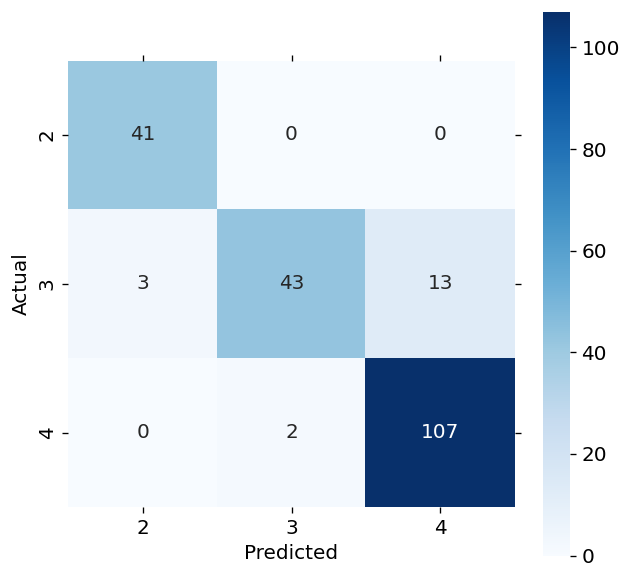

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6,6), dpi=120)
mean, var = m.predict_f(X_total.values)
preds_new = scaler2.inverse_transform(mean.numpy().reshape(-1,1))
stds = y_scaler.inverse_transform_std(np.sqrt(var.numpy().reshape(1,-1)[0]))
classified = [2 if val < 2.5 else 3 if val < 3.5 else 4 for val in preds_new]
labels = scaler2.inverse_transform(Y_total.values.reshape(-1,1)).reshape(-1,1)
# testing set performance
sns.heatmap(confusion_matrix(labels, classified), annot=True, square=True, fmt='g', cmap="Blues")
plt.yticks([0.5, 1.5, 2.5], [2, 3, 4])
plt.xticks([0.5, 1.5, 2.5], [2, 3, 4])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.savefig('confusion_new.png')
files.download('confusion_new.png')
plt.show()

In [ ]:
# Unseen data
# training set
mean, var = m.predict_f(X_total.values)
preds = scaler2.inverse_transform(mean.numpy().reshape(-1,1))
stds = y_scaler.inverse_transform_std(np.sqrt(var.numpy().reshape(1,-1)[0]))
classified = [2 if val < 2.5 else 3 if val < 3.5 else 4 for val in preds]
labels = scaler2.inverse_transform(Y_total.values.reshape(-1,1)).reshape(-1,1)
from sklearn.metrics import classification_report
np.round(pd.DataFrame(classification_report(labels, classified, output_dict=True)).T, 4)

,precision,recall,f1-score,support
2.0,0.9318,1.0000,0.9647,41.0000
3.0,0.9556,0.7288,0.8269,59.0000
4.0,0.8917,0.9817,0.9345,109.0000
accuracy,0.9139,0.9139,0.9139,0.9139
macro avg,0.9263,0.9035,0.9087,209.0000
weighted avg,0.9176,0.9139,0.9101,209.0000


In [ ]:
# data_raw_2['Predicted pipe size'] = preds
# data_raw_2.to_csv('special_samples.csv',  index=None)
# files.download('special_samples.csv')

In [ ]:
# data_raw_2['Predicted pipe size'] = classified
# data_raw_2

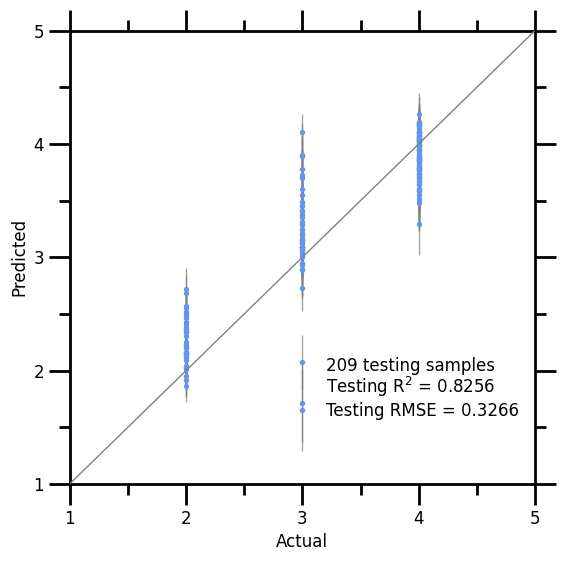

In [ ]:
Y_total_og = scaler2.inverse_transform(Y_total)
plt.figure(figsize=(6,6),dpi=100)
plt.plot([1, 5],[1, 5], color="grey", label="theoretical", zorder = 4, linewidth=1)
plt.errorbar(np.array(Y_total_og).reshape(-1,), np.array(y_pred_new).reshape(-1,), stds, elinewidth=1, ecolor="tab:grey", alpha =0.7, ls="None") 
plt.scatter(np.array(Y_total_og).reshape(-1,), np.array(y_pred_new).reshape(-1,), s=5+3, zorder=4, color="cornflowerblue")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.xlim([1, 5]); plt.ylim([1, 5])
plt.text(3.2, 2, "%d testing samples" %X_total.shape[0], fontsize=12)
plt.text(3.2, 1.8, "Testing R$^2$ = %.4f" %round(r2_score(Y_total_og, y_pred_new),4), fontsize=12)
plt.text(3.2, 1.6, "Testing RMSE = %.4f" %round(np.sqrt(mean_squared_error(Y_total_og, y_pred_new)),4), fontsize=12)
plt.axes().yaxis.set_major_locator(MultipleLocator(1))
plt.axes().yaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().xaxis.set_major_locator(MultipleLocator(1))
plt.axes().xaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().tick_params(which='major', length=15,width=2)
plt.axes().tick_params(which='minor', length=8,width=2)
plt.axes().tick_params(axis='y', labelright=False)
# plt.savefig('testing.jpg', bbox_inches='tight')
# files.download('testing.jpg')
plt.show()

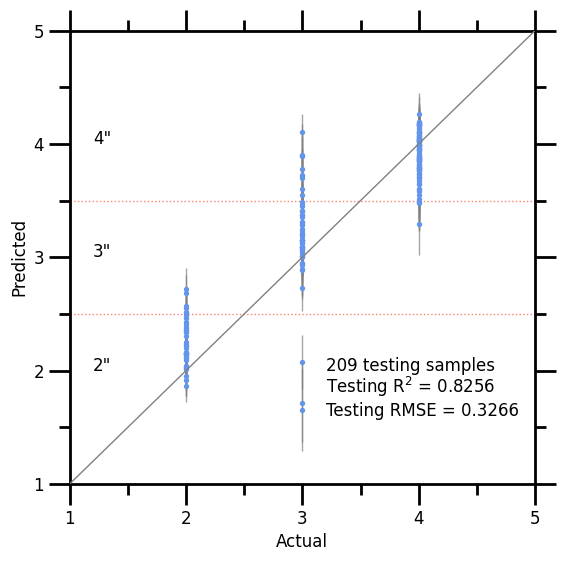

In [ ]:
Y_total_og = scaler2.inverse_transform(Y_total)
plt.figure(figsize=(6,6),dpi=100)
plt.plot([1, 5],[1, 5], color="grey", label="theoretical", zorder = 4, linewidth=1)
plt.errorbar(np.array(Y_total_og).reshape(-1,), np.array(y_pred_new).reshape(-1,), stds, elinewidth=1, ecolor="tab:grey", alpha =0.7, ls="None") 
plt.scatter(np.array(Y_total_og).reshape(-1,), np.array(y_pred_new).reshape(-1,), s=5+3, zorder=4, color="cornflowerblue")
plt.plot([1, 5], [2.5, 2.5], ":", linewidth=1, color="salmon")
plt.plot([1, 5], [3.5, 3.5], ":", linewidth=1, color="salmon")
plt.text(1.2, 2, '2"')
plt.text(1.2, 3, '3"')
plt.text(1.2, 4, '4"')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.xlim([1, 5]); plt.ylim([1, 5])
plt.text(3.2, 2, "%d testing samples" %X_total.shape[0], fontsize=12)
plt.text(3.2, 1.8, "Testing R$^2$ = %.4f" %round(r2_score(Y_total_og, y_pred_new),4), fontsize=12)
plt.text(3.2, 1.6, "Testing RMSE = %.4f" %round(np.sqrt(mean_squared_error(Y_total_og, y_pred_new)),4), fontsize=12)
plt.axes().yaxis.set_major_locator(MultipleLocator(1))
plt.axes().yaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().xaxis.set_major_locator(MultipleLocator(1))
plt.axes().xaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().tick_params(which='major', length=15,width=2)
plt.axes().tick_params(which='minor', length=8,width=2)
plt.axes().tick_params(axis='y', labelright=False)
# plt.savefig('testing_classification.jpg', bbox_inches='tight')
# files.download('testing_classification.jpg')
plt.show()

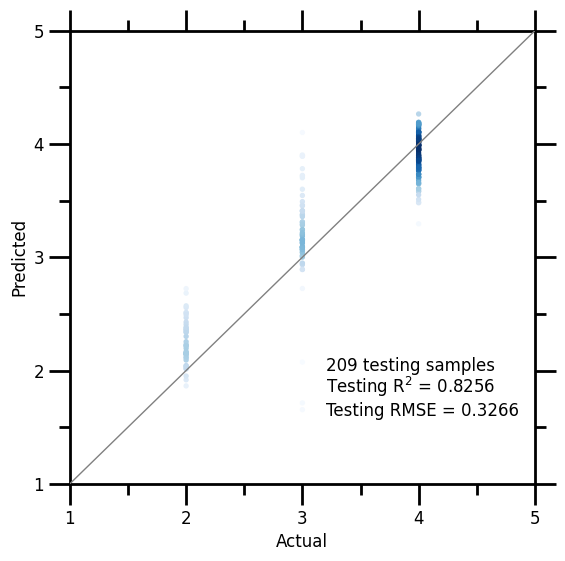

In [ ]:
Y_total_og = scaler2.inverse_transform(Y_total)
xy = np.vstack([Y_total_og.reshape(1, -1), y_pred_new.reshape(1, -1)])
z = gaussian_kde(xy)(xy)
plt.figure(figsize=(6,6),dpi=100)
plt.plot([1, 5],[1, 5], color="grey", label="theoretical", zorder = 4, linewidth=1)
plt.scatter(np.array(Y_total_og).reshape(-1,), np.array(y_pred_new).reshape(-1,), s=5+3, zorder=4, c=z, cmap='Blues')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.xlim([1, 5]); plt.ylim([1, 5])
plt.text(3.2, 2, "%d testing samples" %X_total.shape[0], fontsize=12)
plt.text(3.2, 1.8, "Testing R$^2$ = %.4f" %round(r2_score(Y_total_og, y_pred_new),4), fontsize=12)
plt.text(3.2, 1.6, "Testing RMSE = %.4f" %round(np.sqrt(mean_squared_error(Y_total_og, y_pred_new)),4), fontsize=12)
plt.axes().yaxis.set_major_locator(MultipleLocator(1))
plt.axes().yaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().xaxis.set_major_locator(MultipleLocator(1))
plt.axes().xaxis.set_minor_locator(MultipleLocator(1/2))
plt.axes().tick_params(which='major', length=15,width=2)
plt.axes().tick_params(which='minor', length=8,width=2)
plt.axes().tick_params(axis='y', labelright=False)
# plt.savefig('testing_density.jpg', bbox_inches='tight')
# files.download('testing_density.jpg')
plt.show()

### Rejoining with original dataset

In [ ]:
# Training dataframe
training = data_raw.iloc[X_train.index.tolist(), :]
training_preds = pd.Series([2 if val < 2.5 else 3 if val < 3.5 else 4 for val in preds_train], index = training.index.tolist())
training['Predicted pump size'] = training_preds

# Testing dataframe
testing = data_raw.iloc[X_test.index.tolist(), :]
testing_preds = pd.Series([2 if val < 2.5 else 3 if val < 3.5 else 4 for val in preds_test], index = testing.index.tolist())
testing['Predicted pump size'] = testing_preds

# Concatenated dataframe
predictions_df = pd.concat([training, testing], axis = 0).sort_index()

In [ ]:
predictions_df.to_excel('USconcrete_gradiation_new_with_predictions.xlsx', index = False)
files.download('USconcrete_gradiation_new_with_predictions.xlsx')

In [ ]:
# Data from new plant
new_plant_df = data_raw_2
new_plant_df['Predicted pump size'] = pd.Series([2 if val < 2.5 else 3 if val < 3.5 else 4 for val in preds])
new_plant_df['Predicted pump size (cont)'] = pd.Series([round(float(pred), 4) for pred in preds])

In [ ]:
data_raw_2[data_raw_2['Predicted pump size'] != data_raw_2['Labeled pipe size']].sort_values('Predicted pump size (cont)')

In [ ]:
new_plant_df.to_excel('USconcrete_gradiation_new_plant_with_predictions.xlsx', index = False)
files.download('USconcrete_gradiation_new_plant_with_predictions.xlsx')

### SHAP Analysis

In [ ]:
# library install and import
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 8.0 MB/s 


In [ ]:
# function to make the predictions in KernelExplainer
def makeGPRPredictions(X):
    if type(X) == pd.core.frame.DataFrame:
        mean, var = m.predict_f(X.values)
    elif type(X) == np.ndarray:
        mean, var = m.predict_f(X)
    mean, var = mean.numpy().reshape(1,-1)[0], np.sqrt(var.numpy().reshape(1,-1)[0])
    return mean

In [ ]:
K = 200
background = shap.kmeans(X, K)
samples = background.data.copy() 
explainer = shap.KernelExplainer(makeGPRPredictions, background.data, link="identity")
print("Step 1 done.")
shap_values = explainer.shap_values(samples, nsamples=1100-800)
print("Step 2 done.")

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Step 1 done.


  0%|          | 0/200 [00:00<?, ?it/s]

Step 2 done.


SHAP Summary Plot

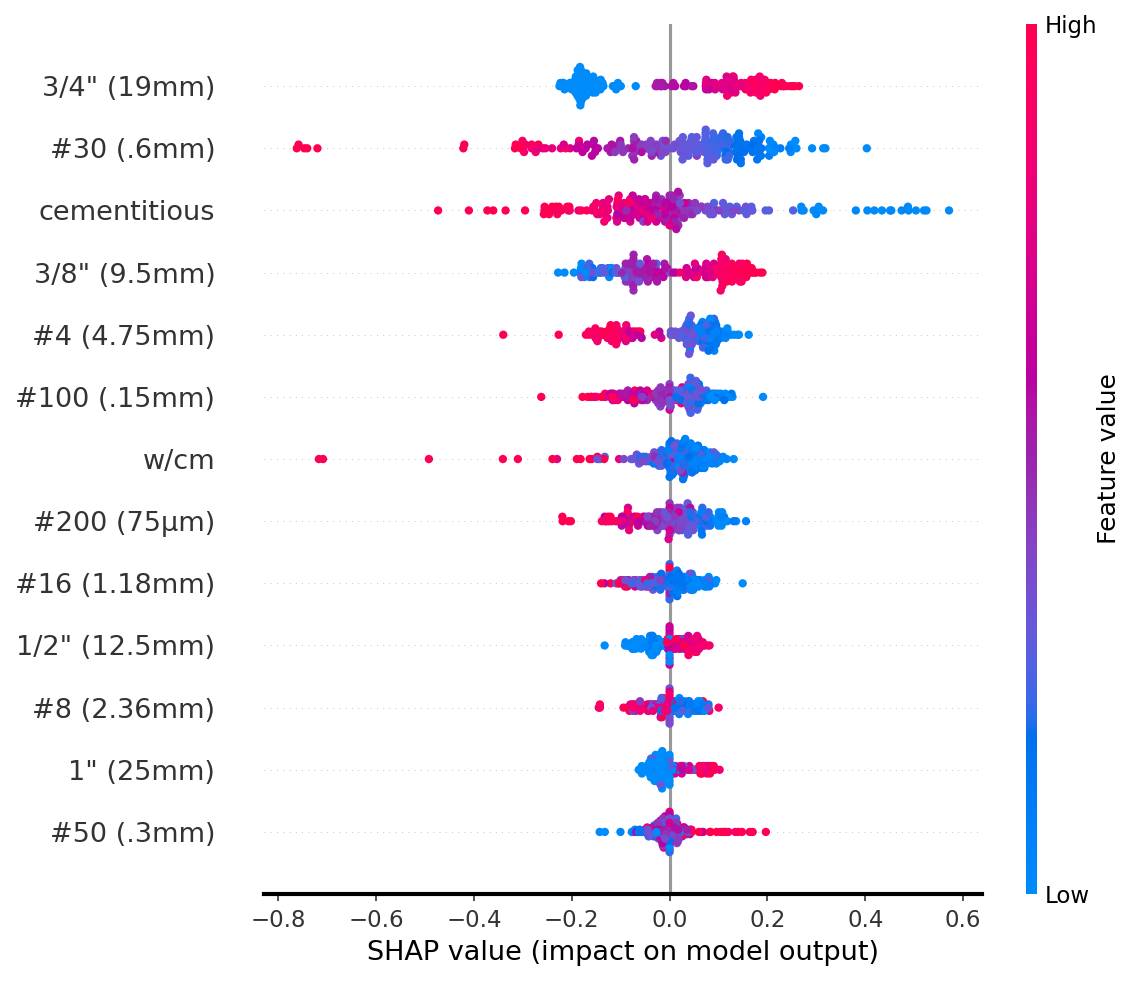

In [ ]:
samples = pd.DataFrame(samples)
samples.columns = X.columns
plt.figure(dpi=150)
shap.summary_plot(shap_values*scaler2.scale_, samples, show=False)
plt.savefig('shap.png', bbox_inches='tight')
# files.download('shap.png')

SHAP Dependence Plots

In [ ]:
scaler3 = preprocessing.StandardScaler() 
scaler3.fit(data_feature.loc[:, X.columns]) 
samples2 = pd.DataFrame(scaler3.inverse_transform(samples))
samples2.columns = X.columns

In [ ]:
# List of columns
X.columns

Index(['w/cm', 'cementitious', '1" (25mm)', '3/4" (19mm)', '1/2" (12.5mm)',
       '3/8" (9.5mm)', '#4 (4.75mm)', '#8 (2.36mm)', '#16 (1.18mm)',
       '#30 (.6mm)', '#50 (.3mm)', '#100 (.15mm)', '#200 (75µm)'],
      dtype='object')

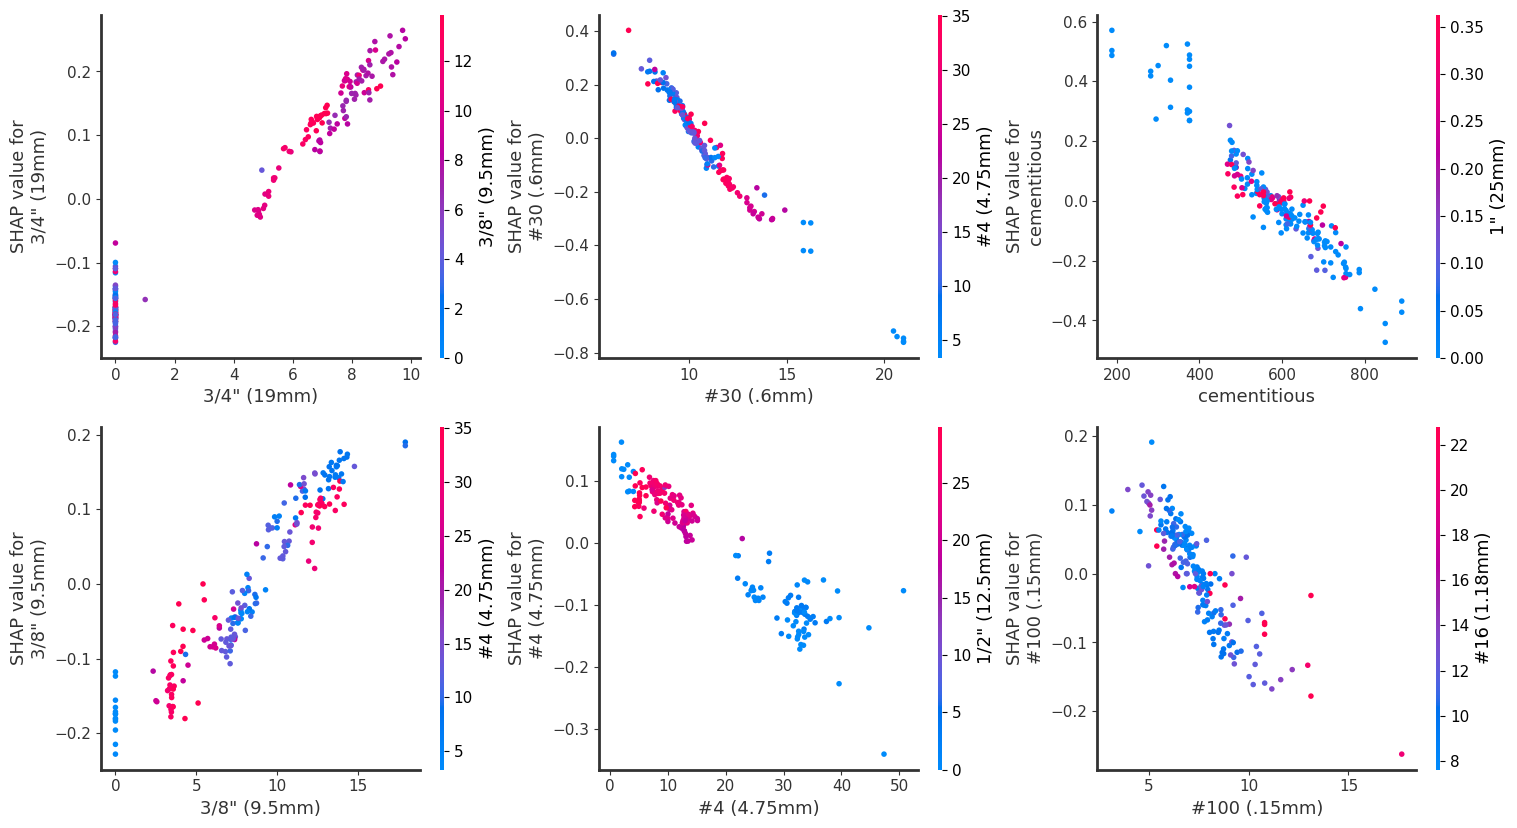

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     =100)
plt.subplots_adjust(wspace=0.25)
axes = axes.ravel()
# Most relevant features
for i, col in enumerate(['3/4" (19mm)', '#30 (.6mm)', 'cementitious', '3/8" (9.5mm)', '#4 (4.75mm)', '#100 (.15mm)']):
    shap.dependence_plot(col, shap_values*scaler2.scale_, samples2, ax=axes[i], show=False)
# for i in range(20, 25):
#     axes[i].axis("off")
# plt.savefig('dependence_plots.png', bbox_inches='tight')
# files.download('dependence_plots.png')
plt.show()

#### SHAP-based feature importance and clustering

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score

X_dl = data_raw.loc[:, feat]
Y_dl = data_raw['Labeled pipe size']

X_train, X_test, y_train, y_test = train_test_split(X_dl, Y_dl, test_size=0.2, random_state=1213)

# Run GBM on training dataset
# Create xgboost object
model = xgb.XGBRegressor(objective="reg:squarederror", missing=1, seed=42)

# Fit xgboost onto data
model.fit(X_train
    ,y_train
    ,verbose=True
    ,early_stopping_rounds=10
    ,eval_metric='rmse'
    ,eval_set=[(X_test,y_test)])

[0]	validation_0-rmse:2.56024
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.30948
[2]	validation_0-rmse:2.08413
[3]	validation_0-rmse:1.88164
[4]	validation_0-rmse:1.69982
[5]	validation_0-rmse:1.53678
[6]	validation_0-rmse:1.39059
[7]	validation_0-rmse:1.25955
[8]	validation_0-rmse:1.14257
[9]	validation_0-rmse:1.03798
[10]	validation_0-rmse:0.944562
[11]	validation_0-rmse:0.861225
[12]	validation_0-rmse:0.787393
[13]	validation_0-rmse:0.721758
[14]	validation_0-rmse:0.663477
[15]	validation_0-rmse:0.612465
[16]	validation_0-rmse:0.567019
[17]	validation_0-rmse:0.527611
[18]	validation_0-rmse:0.493353
[19]	validation_0-rmse:0.463521
[20]	validation_0-rmse:0.437846
[21]	validation_0-rmse:0.415765
[22]	validation_0-rmse:0.397142
[23]	validation_0-rmse:0.380492
[24]	validation_0-rmse:0.367033
[25]	validation_0-rmse:0.35521
[26]	validation_0-rmse:0.345357
[27]	validation_0-rmse:0.337283
[28]	validation_0-rmse:0.329994
[29]	validation_0-rmse:0.323

XGBRegressor(missing=1, objective='reg:squarederror', seed=42)

[01:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

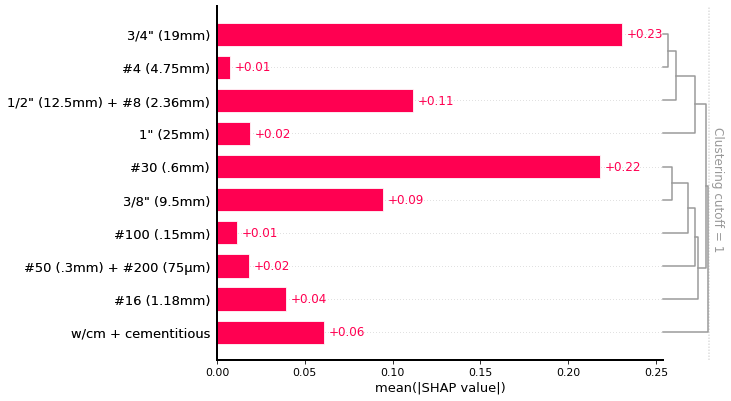

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_dl)
clust = shap.utils.hclust(X_dl, Y_dl, linkage="complete")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1, show = False) 
# plt.savefig('clusters.png', bbox_inches='tight', dpi=300)
# files.download('clusters.png')

In [ ]:
# shap.plots.scatter(shap_values[:, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

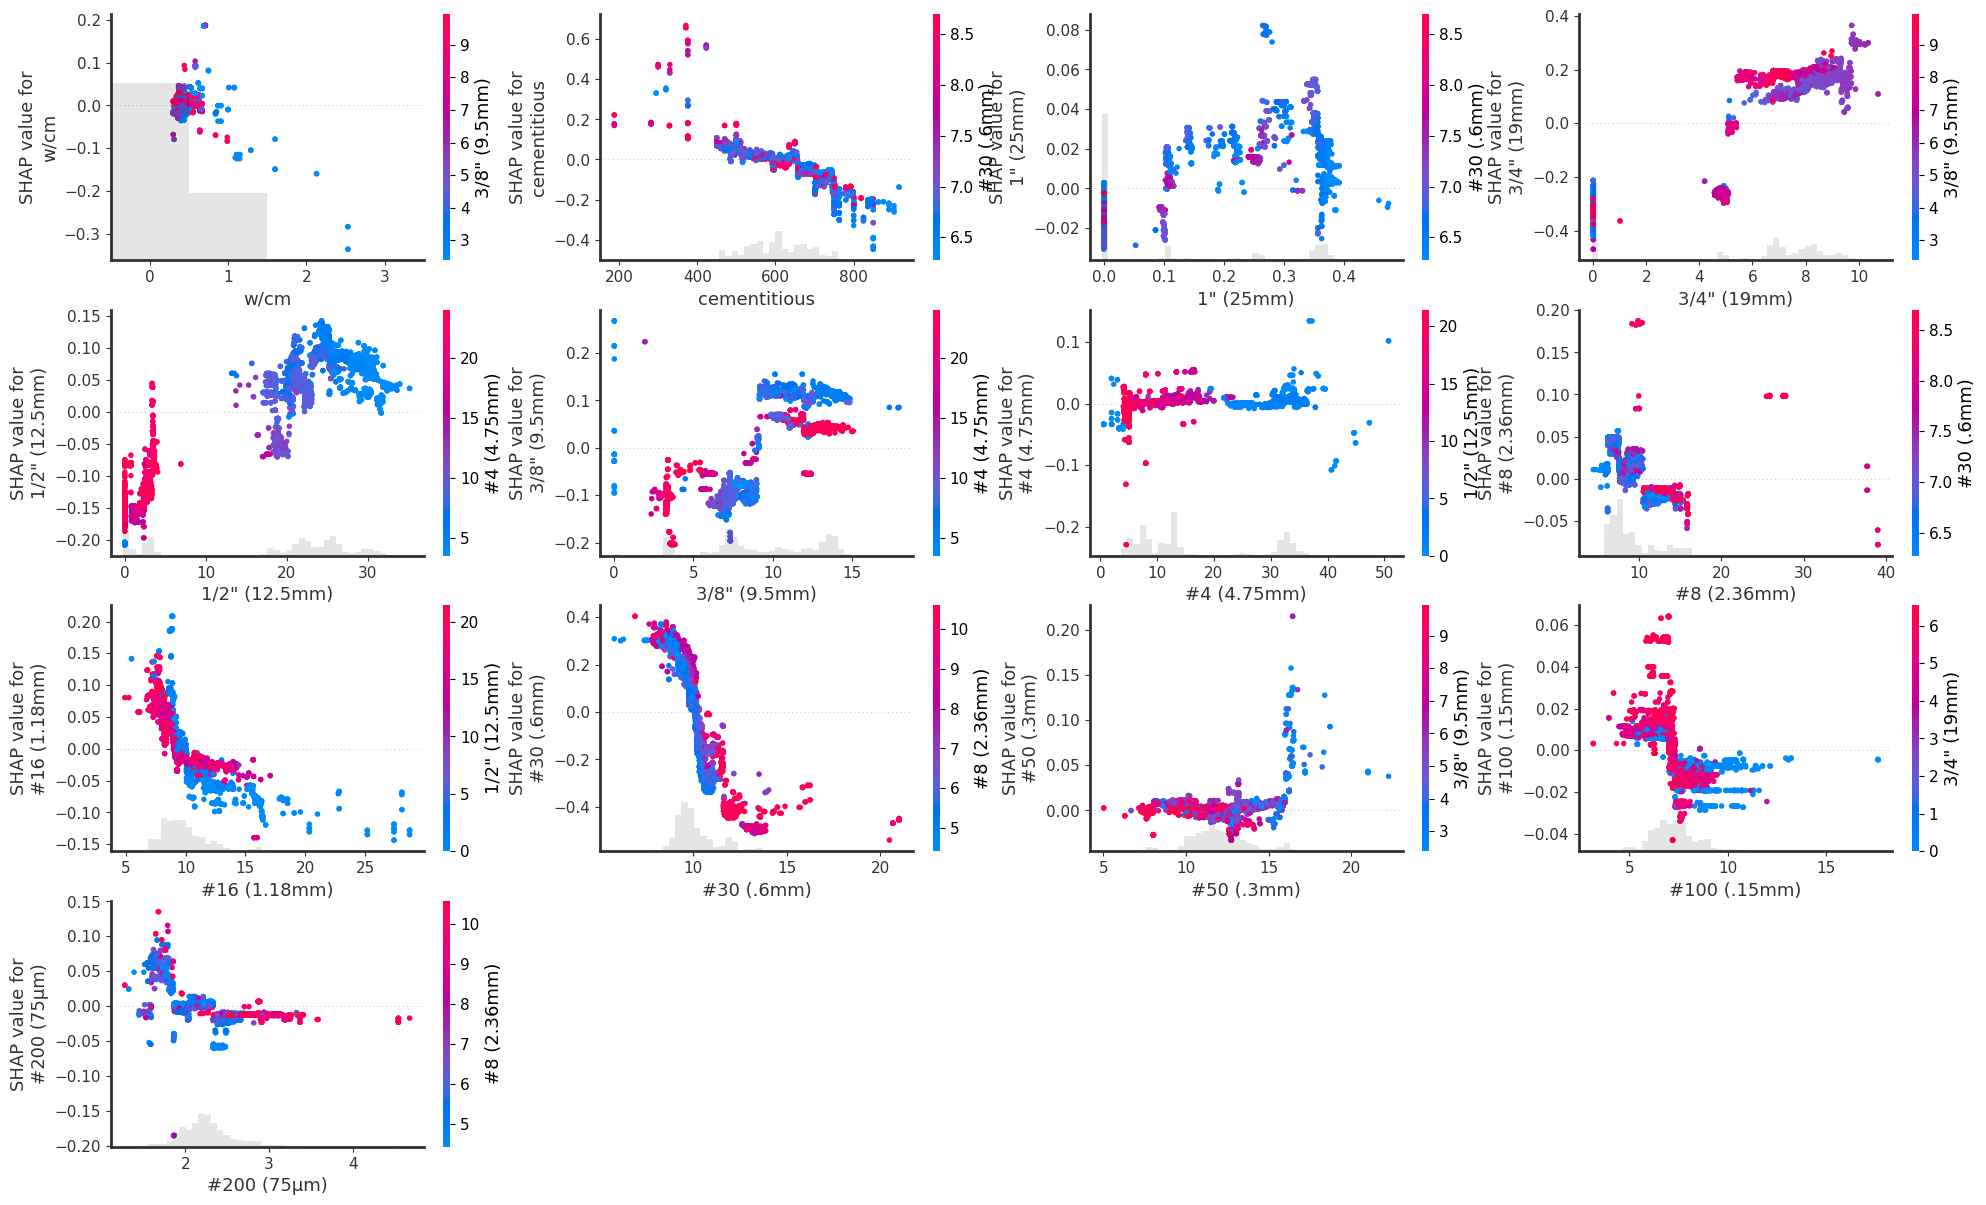

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(24, 15), dpi                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     =100)
plt.subplots_adjust(wspace=0.25)
axes = axes.ravel()
# Most relevant features
for i, col in enumerate(feat):
    shap.plots.scatter(shap_values[:, col], shap_values*scaler2.scale_, ax=axes[i], show=False)
for i in range(13, 16):
    axes[i].axis("off")
plt.savefig('scatterplots.pdf')
files.download('scatterplots.pdf')
plt.show()

#### Scatterplots based on feature clustering

In [ ]:
import sklearn
from sklearn.metrics import r2_score
data_raw.columns

Index(['w/cm', 'cementitious', 'Coarse agg total', 'Fine agg total',
       'Coarse agg (>1/2" )', 'Coarse agg (<1/2" )', '2" (50mm)', '1" (25mm)',
       '3/4" (19mm)', '1/2" (12.5mm)', '3/8" (9.5mm)', '#4 (4.75mm)',
       '#8 (2.36mm)', '#16 (1.18mm)', '#30 (.6mm)', '#50 (.3mm)',
       '#100 (.15mm)', '#200 (75µm)', 'Labeled pipe size'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

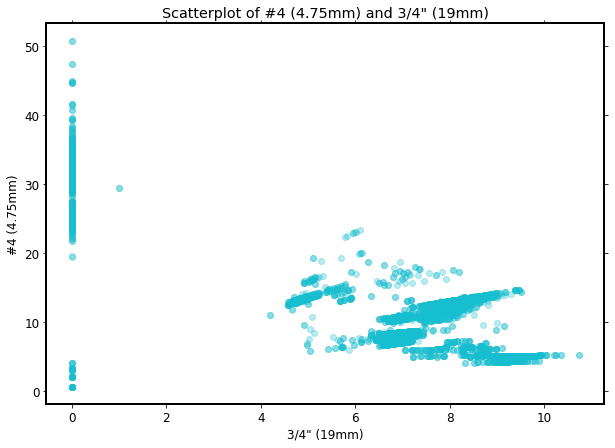

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(data_raw['3/4" (19mm)'], data_raw['#4 (4.75mm)'], color="tab:cyan", alpha=0.3)
plt.xlabel('3/4" (19mm)', fontsize=12)
plt.ylabel('#4 (4.75mm)', fontsize=12)
plt.title('Scatterplot of #4 (4.75mm) and 3/4" (19mm)')
# plt.savefig('scatterplot1.png', dpi=300)
# files.download('scatterplot1.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

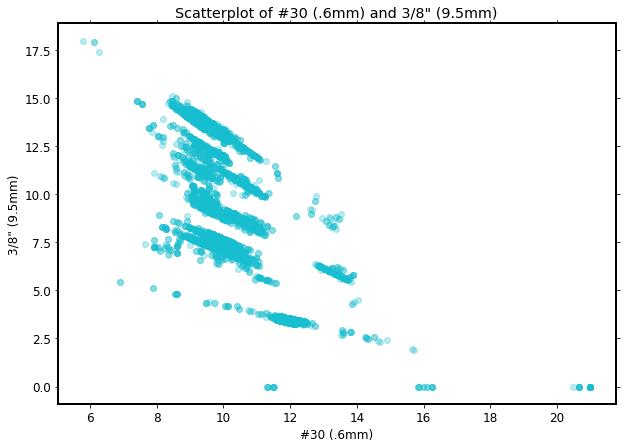

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(data_raw['#30 (.6mm)'], data_raw['3/8" (9.5mm)'], color="tab:cyan", alpha=0.3)
plt.xlabel('#30 (.6mm)', fontsize=12)
plt.ylabel('3/8" (9.5mm)', fontsize=12)
plt.title('Scatterplot of #30 (.6mm) and 3/8" (9.5mm)')
plt.savefig('scatterplot2.png', dpi=300)
files.download('scatterplot2.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

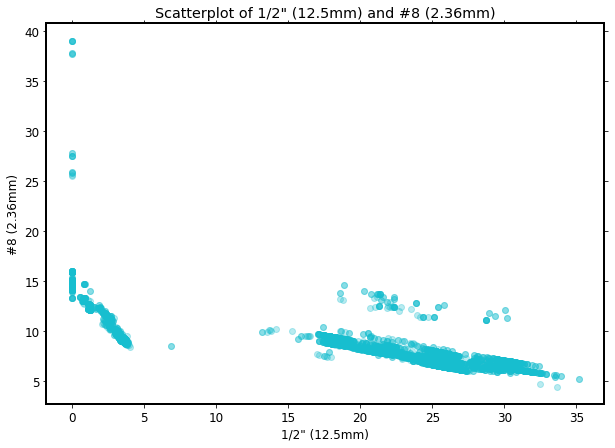

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(data_raw['1/2" (12.5mm)'], data_raw['#8 (2.36mm)'], color="tab:cyan", alpha=0.3)
plt.xlabel('1/2" (12.5mm)', fontsize=12)
plt.ylabel('#8 (2.36mm)', fontsize=12)
plt.title('Scatterplot of 1/2" (12.5mm) and #8 (2.36mm)')
# plt.savefig('scatterplot3.png', dpi=300)
# files.download('scatterplot3.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

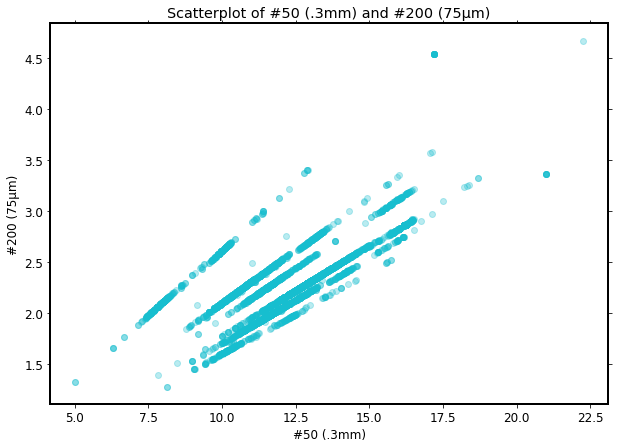

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(data_raw['#50 (.3mm)'], data_raw['#200 (75µm)'], color="tab:cyan", alpha=0.3)
plt.xlabel('#50 (.3mm)', fontsize=12)
plt.ylabel('#200 (75µm)', fontsize=12)
plt.title('Scatterplot of #50 (.3mm) and #200 (75µm)')
# plt.savefig('scatterplot4.png', dpi=300)
# files.download('scatterplot4.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

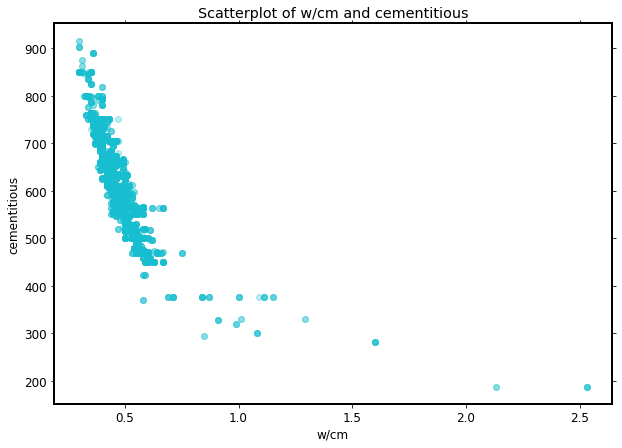

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(data_raw['w/cm'], data_raw['cementitious'], color="tab:cyan", alpha=0.3)
plt.xlabel('w/cm', fontsize=12)
plt.ylabel('cementitious', fontsize=12)
plt.title('Scatterplot of w/cm and cementitious')
# plt.savefig('scatterplot5.png', dpi=300)
# files.download('scatterplot5.png')

### k-means clustering & LOCO-CV

K-means Elbow Method

In [ ]:
from sklearn.cluster import KMeans
distortions = []
ks = range(10, 201, 5)
# Relevant set of features
features = feat
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_feature_scaled.loc[:, features])
    distortions.append(kmeans.inertia_)

In [ ]:
plt.figure(figsize=(6, 6), dpi=150)
plt.plot(ks, distortions, "-o", markersize=3.5)
plt.xlabel("k")
plt.ylabel("Distortion")
plt.ylim([0, max(distortions) + 50])
plt.show()

Based on the plot, 50 seems to be a good elbow point for the value of $k$. 

LOCO-CV

Code modified based on: https://github.com/globus-labs/loco-cv.

In [ ]:
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, BaseCrossValidator, cross_val_predict, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
from tqdm import tqdm_notebook as tqdm
class LocoCV(BaseCrossValidator):
    """
    Generates train/test splits for Leave-One-Cluster-Out Cross-Validation
    Follows the API for scikit-learns cross-validation classes
    
    Parameters
    ----------
    clusterer : ClustererMixin, tool used to generate clusters"""
    
    def __init__(self, clusterer=KMeans()):
        self.clusterer = clusterer
        
    def _iter_test_masks(self, X, y=None, groups=None):
                # Train the clusterer and generate cluster labels
        labels = self.clusterer.fit_predict(X)
        
        # Determine the number of clusters
        clust_labels = np.unique(labels)
        if len(clust_labels) < 2:
            raise ValueError('Clusterer produced < 2 labels. Cannot use for LOCO CV')
            
        # Loop thorugh the clusters
        for label in clust_labels:
            yield labels == label
    
    def get_n_splits(self, X, y=None, groups=None):
        return len(np.unique(self.clusterer.fit_predict(X)))

In [ ]:
def createGPR(X_train, y_train, variance=0.15, trainable = False):
    '''
    Function to create a GPR model (GPflow implementation). 

    Parameters
    ----------
    X_train: Dataframe for the training features.
    y_train: Dataframe for the training target variable.
    variance: float, variance.likelihood used in the GPR model.
    trainable: boolean, if True, all parameters in the GPR model can be optimized. 

    Return
    ----------
    Optimized GPR model. 
    '''
    k = gpflow.kernels.SquaredExponential() + gpflow.kernels.Linear() + gpflow.kernels.White()
    m = gpflow.models.GPR(data=(X_train, y_train), 
                          kernel=k, mean_function=None)
    if not trainable:
        m.likelihood.variance.assign(variance)
        gpflow.set_trainable(m.likelihood.variance, False)
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(m.training_loss, variables=m.trainable_variables, 
                   options=dict(maxiters=5000, disp=True))
    return m

K-means Clustering

In [ ]:
ncluster = 30
kmeans = Pipeline([
    ('kmeans', KMeans(n_clusters=ncluster, random_state=1))
])

In [ ]:
# create the train-test/validation splits
train_index = []
test_index = []
features = ["cementitious", "Coarse agg total", "Fine agg total"]
for item in LocoCV(kmeans).split(data_feature_scaled.loc[:, features]): 
  train_index.append(item[0])
  test_index.append(item[1])

In [ ]:
from sklearn.metrics import classification_report
kmeans.set_params(kmeans__random_state=1)
r2_train = []; r2_test = []
rmse_train = []; rmse_test = []
sd_train = []; sd_test = []
train_table = []; test_table = []
train_class = {}; test_class = {}
for index in range(ncluster):
    print(index)
    # traing the GPR model
    X_train = data_feature_scaled.loc[train_index[index], :]
    y_train = data_label_scaled.loc[train_index[index], :]
    X_test = data_feature_scaled.loc[test_index[index], :]
    y_test = data_label_scaled.loc[test_index[index], :]
    m = createGPR(X_train, y_train, variance=1.5)

    # training set performance
    mean, var = m.predict_f(X_train.values)
    r2_train.append(r2_score(y_train.values.reshape(1,-1)[0], mean.numpy().reshape(1,-1)[0]))
    y_true = scaler2.inverse_transform(y_train.values.reshape(-1, 1))
    y_pred = scaler2.inverse_transform(mean.numpy())
    rmse_train.append(np.sqrt(mean_squared_error(y_true, y_pred)))
    y_scaler = MyScaler()
    y_scaler.fit(y_true)
    sd_train.append(np.mean(y_scaler.inverse_transform_std(var.numpy().reshape(-1,1))))
    classified = [2 if val < 2.5 else 3 if val < 3.5 else 4 for val in y_pred]
    labels = scaler2.inverse_transform(y_train.values.reshape(-1,1)).reshape(-1,1)
    train_table.append(np.round(pd.DataFrame(classification_report(labels, classified, output_dict=True)).T, 4))
    train_class[index] = classified

    # testing set performance
    mean, var = m.predict_f(X_test.values)
    r2_test.append(r2_score(y_test.values.reshape(1,-1)[0], mean.numpy().reshape(1,-1)[0]))
    y_true = scaler2.inverse_transform(y_test.values.reshape(-1, 1))
    y_pred = scaler2.inverse_transform(mean.numpy())
    rmse_test.append(np.sqrt(mean_squared_error(y_true, y_pred)))
    y_scaler = MyScaler()
    y_scaler.fit(y_true)
    sd_test.append(np.mean(y_scaler.inverse_transform_std(var.numpy().reshape(-1, 1))))
    classified = [2 if val < 2.5 else 3 if val < 3.5 else 4 for val in y_pred]
    labels = scaler2.inverse_transform(y_test.values.reshape(-1,1)).reshape(-1,1)
    test_table.append(np.round(pd.DataFrame(classification_report(labels, classified, output_dict=True)).T, 4))
    test_class[index] = classified

In [ ]:
# fig, axes = plt.subplots(10, 4+2, figsize=(30, 48), dpi=200)
# fig.subplots_adjust(wspace=0.4, hspace=0.35)
# axes = axes.flatten()
# for i in range(10):
#     # first four plots of each row: distribution of the features
#     for j, feat in enumerate(features):
#         sns.distplot(data_feature.loc[train_index[i], feat], label="Training (%d)" %len(train_index[i]), ax=axes[i*6+j])
#         sns.distplot(data_feature.loc[test_index[i], feat], label="Testing (%d)" %len(test_index[i]), ax=axes[i*6+j])
#         axes[i*6+j].legend(frameon=False, ncol=1)
#         plt.xlabel(feat)
#     # fifth plot of each row: confusion matrix on the training set
#     sns.heatmap(confusion_matrix(data_label.loc[train_index[i]], np.array(train_class[i])), annot=True, 
#                 square=True, fmt='g', cmap="Blues", ax=axes[i*6+j+1])
#     axes[i*6+j+1].set_yticks([0.5, 1.5, 2.5])
#     axes[i*6+j+1].set_xticks([0.5, 1.5, 2.5])
#     axes[i*6+j+1].set_xticklabels([2, 3, 4])
#     axes[i*6+j+1].set_yticklabels([2, 3, 4])
#     axes[i*6+j+1].set_ylabel("True")
#     axes[i*6+j+1].set_xlabel("Predicted")
#     # sixth plot of each row: confusion matrix on the testing set
#     sns.heatmap(confusion_matrix(data_label.loc[test_index[i]], np.array(test_class[i])), annot=True, 
#                 square=True, fmt='g', cmap="Blues", ax=axes[i*6+j+2])
#     axes[i*6+j+2].set_yticks([0.5, 1.5, 2.5])
#     axes[i*6+j+2].set_xticks([0.5, 1.5, 2.5])
#     axes[i*6+j+2].set_xticklabels([2, 3, 4])
#     axes[i*6+j+2].set_yticklabels([2, 3, 4])
#     axes[i*6+j+2].set_ylabel("True")
# plt.savefig('plots.png')
# files.download('plots.png')
# plt.show()

LOCO-CV Evaluation

In [ ]:
train_accu = [t.iloc[3, 0] for t in train_table]
test_accu  = [t.iloc[3, 0] for t in test_table]
train_precision = [np.mean(t.iloc[[0,1,2], 0]) for t in train_table]
test_precision  = [np.mean(t.iloc[[0,1,2], 0]) for t in test_table]
train_recall = [np.mean(t.iloc[[0,1,2], 1]) for t in train_table]
test_recall  = [np.mean(t.iloc[[0,1,2], 1]) for t in test_table]

In [ ]:
plt.figure(figsize=(6,6), dpi=150)
# accuracy curves
plt.errorbar(range(1, len(train_accu)+1), train_accu, fmt="-o", label="Training accuracy", markersize=4)
plt.errorbar(range(1, len(train_accu)+1), test_accu, fmt="-o", label="Testing accuracy", markersize=4)
# precision curves
# plt.errorbar(range(1, len(r2_train)+1), train_precision, fmt="-s", label="Training precision")
# plt.errorbar(range(1, len(r2_test)+1), test_precision, fmt="-s", label="Testing precision")
# recall curves
# plt.errorbar(range(1, len(r2_train)+1), train_recall, fmt="-*", label="Training recall")
# plt.errorbar(range(1, len(r2_test)+1), test_recall, fmt="-*", label="Testing recall")
plt.xlabel("Cluster")
plt.ylabel("Accuracy")
plt.ylim([0, 1.1])
plt.legend(frameon=False, ncol=3, fontsize=8, loc="lower left")
# plt.savefig('clusters.png')
# files.download('clusters.png')
plt.show()

Testing/Validation Size Distribution

In [ ]:
train_lens = [len(i) for i in train_index]
test_lens = [len(i) for i in test_index]

In [ ]:
plt.figure(figsize=(6,6), dpi=150)
plt.bar(range(1, len(r2_test)+1), test_lens)
plt.xlabel("Cluster")
plt.ylabel("Testing samples ($n$)")
plt.legend(frameon=False, ncol=3, fontsize=8, loc="lower left")
# plt.savefig('cluster_size.png')
# files.download('cluster_size.png')
plt.show()

LOCO-CV with a Single Feature

In [ ]:
ncluster = 8
kmeans = Pipeline([
    ('kmeans', KMeans(n_clusters=ncluster, random_state=1))
])

In [ ]:
# create the train-test/validation splits
train_index = []
test_index = []
features = ["cementitious", "Coarse agg total", "Fine agg total", "w/cm"]
feature = features[3]
for item in LocoCV(kmeans).split(data_feature_scaled.loc[:, [feature]]): 
  train_index.append(item[0])
  test_index.append(item[1])

In [ ]:
# find the centriod and sort the clusters
cluster = []
for index in range(len(test_index)):
  X_test = data_feature_scaled.loc[test_index[index], :]
  cluster.append(np.mean(X_test[feature]))
order = np.argsort(cluster)

In [ ]:
kmeans.set_params(kmeans__random_state=1)
r2_train = []; r2_test = []
rmse_train = []; rmse_test = []
sd_train = []; sd_test = []
train_table = []; test_table = []
for index in order:
    print(index)
    X_train = data_feature_scaled.loc[train_index[index], :]
    y_train = data_label_scaled.loc[train_index[index], :]
    X_test = data_feature_scaled.loc[test_index[index], :]
    y_test = data_label_scaled.loc[test_index[index], :]
    m = createGPR(X_train, y_train, variance=0.60)

    mean, var = m.predict_f(X_train.values)
    r2_train.append(r2_score(y_train.values.reshape(1,-1)[0], mean.numpy().reshape(1,-1)[0]))
    y_true = scaler2.inverse_transform(y_train.values.reshape(-1, 1))
    y_pred = scaler2.inverse_transform(mean.numpy())
    rmse_train.append(np.sqrt(mean_squared_error(y_true, y_pred)))
    y_scaler = MyScaler()
    y_scaler.fit(y_true)
    sd_train.append(np.mean(y_scaler.inverse_transform_std(var.numpy().reshape(-1,1))))
    classified = [2 if val < 2.5 else 3 if val < 3.5 else 4 for val in y_pred]
    labels = scaler2.inverse_transform(y_train.values.reshape(-1,1)).reshape(-1,1)
    train_table.append(np.round(pd.DataFrame(classification_report(labels, classified, output_dict=True)).T, 4))

    mean, var = m.predict_f(X_test.values)
    r2_test.append(r2_score(y_test.values.reshape(1,-1)[0], mean.numpy().reshape(1,-1)[0]))
    y_true = scaler2.inverse_transform(y_test.values.reshape(-1, 1))
    y_pred = scaler2.inverse_transform(mean.numpy())
    rmse_test.append(np.sqrt(mean_squared_error(y_true, y_pred)))
    y_scaler = MyScaler()
    y_scaler.fit(y_true)
    sd_test.append(np.mean(y_scaler.inverse_transform_std(var.numpy().reshape(-1, 1))))
    classified = [2 if val < 2.5 else 3 if val < 3.5 else 4 for val in y_pred]
    labels = scaler2.inverse_transform(y_test.values.reshape(-1,1)).reshape(-1,1)
    test_table.append(np.round(pd.DataFrame(classification_report(labels, classified, output_dict=True)).T, 4))

In [ ]:
# inverse the feature back to its original scale
X_mini = data_feature_scaled.iloc[:len(rmse_train), :]
X_mini[feature] = np.round(np.sort(cluster), 2)
X_mini = np.round(pd.DataFrame(scaler1.inverse_transform(X_mini), columns=data_feature_scaled.columns), 2)

In [ ]:
plt.figure(figsize=(6,6), dpi=150)
plt.errorbar(range(1, len(rmse_train)+1), rmse_train, sd_train, fmt="-o", label="Training")
plt.errorbar(range(1, len(rmse_test)+1), rmse_test, sd_test, fmt="-o", label="Testing")
plt.xlabel(feature)
plt.ylabel("RMSE")
plt.ylim([0, 1])
plt.xlim([0, ncluster+1])
plt.xticks(range(1, len(rmse_train)+1), (np.round(X_mini[feature].values)).astype(int), fontsize=6)
plt.legend()
# plt.savefig('rmse.png', bbox_inches='tight')
# files.download('rmse.png')
plt.show()

In [ ]:
plt.figure(figsize=(6,6), dpi=150)
plt.errorbar(range(1, len(r2_train)+1), r2_train, fmt="-o", label="Training")
plt.errorbar(range(1, len(r2_test)+1), r2_test, fmt="-o", label="Testing")
plt.xlabel(feature)
plt.ylabel("R$^2$")
plt.ylim([-1, 1.1])
plt.xlim([0, ncluster+1])
plt.xticks(range(1, len(rmse_train)+1), (np.round(X_mini[feature].values)).astype(int), fontsize=6)
plt.legend()
# plt.savefig('r2.png', bbox_inches='tight')
# files.download('r2.png')
plt.show()

In [ ]:
train_accu = [t.iloc[3, 0] for t in train_table]
test_accu  = [t.iloc[3, 0] for t in test_table]

In [ ]:
plt.figure(figsize=(6,6), dpi=150)
plt.errorbar(range(1, len(r2_train)+1), train_accu, fmt="-o", label="Training")
plt.errorbar(range(1, len(r2_test)+1), test_accu, fmt="-o", label="Testing")
plt.xlabel(feature)
plt.ylabel("Accuracy")
plt.ylim([0, 1.1])
plt.xlim([0, ncluster+1])
plt.xticks(range(1, len(rmse_train)+1), (np.round(X_mini[feature].values)).astype(int), fontsize=6)
# plt.savefig('wcm_acc.png', bbox_inches='tight')
# files.download('wcm_acc.png')
plt.legend()
plt.show()

Precision and Recall on the 2" Class

In [ ]:
train_precision = [t.iloc[0, 0] for t in train_table]
test_precision  = [t.iloc[0, 0] for t in test_table]
train_recall = [t.iloc[0, 1] for t in train_table]
test_recall  = [t.iloc[0, 1] for t in test_table]

In [ ]:
plt.figure(figsize=(6,6), dpi=150)
plt.errorbar(range(1, len(r2_train)+1), train_precision, fmt="-o", label="Training precision", alpha=0.8)
plt.errorbar(range(1, len(r2_test)+1), test_precision, fmt="-o", label="Testing precision", alpha=0.8)
plt.errorbar(range(1, len(r2_train)+1), train_recall, fmt="-s", label="Training recall", alpha=0.8)
plt.errorbar(range(1, len(r2_test)+1), test_recall, fmt="-s", label="Testing recall", alpha=0.8)
plt.xlabel("feature")
plt.ylabel('2"')
plt.ylim([-0.2, 1.2])
plt.xlim([0, ncluster+1])
plt.xticks(range(1, len(rmse_train)+1), (np.round(X_mini[feature].values)).astype(int), fontsize=6)
plt.legend(prop={'size': 9})
plt.show()